In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score,precision_recall_fscore_support,f1_score
from sklearn.metrics import classification_report
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from pandas.tools.plotting import parallel_coordinates
from math import pi

wine_base = pd.read_csv("Our_dataset/StemmedWord2vecTop3_parsed.csv", index_col=0) 
print(wine_base.columns)
wine_base = wine_base.reset_index()
wine_base= wine_base[pd.notnull(wine_base['description'])]
wine_base.columns

for col in wine_base.columns:
    if(col.startswith("tf")):
            wine_base.drop(col,inplace=True,axis=1)

import re
def get_vintage(df):
    pattern = r"\d{4}"
    vintages = []
    for elem in df.title:
        match = re.findall(pattern,elem)
        year = 0
        if len(match)>1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif y == 7200:
                year = int(match[1])
            else:
                year= y
        elif len(match)==1:
            y= int(match[0])
            if y <1952:
                year = 0
            elif y==3000:
                year == 2009
            elif year == 7200:
                year = 0
            else:
                year = y
        else:
            year = 0
        vintages.append(year)

    se = pd.Series(vintages)
    df['vintage']=se.values 
    df.drop('title',axis=1)
    return df

wine_base = get_vintage(wine_base)
#drop reviwe of wine with ventage =0
wine_base = wine_base[wine_base.vintage != 0]

wine_base = wine_base[pd.notnull(wine_base['country'])]
wine_base = wine_base[pd.notnull(wine_base['taster_name'])]
wine_base = wine_base[pd.notnull(wine_base["variety"])]
wine_base = wine_base[pd.notnull(wine_base["province"])]
wine_base = wine_base[pd.notnull(wine_base["winery"])]

wine_base.drop("title",inplace=True,axis=1)
wine_base = wine_base.dropna()

#keep track of the countries,provinces,taster_names in the database
countries = wine_base["country"].unique().tolist()
provinces = wine_base["province"].unique().tolist()
tasters = wine_base["taster_name"].unique().tolist()

def OneHotEncode(dataframe,column_to_encode,take_whole_dataset=True):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe[[column_to_encode]])
    mapping = {}
    i=0
    for elem in enc.categories_[0]:
        mapping[elem]=i
        i+=1
    resu = enc.transform(dataframe[[column_to_encode]]).toarray()
    if take_whole_dataset:
        for elem in mapping:
            dataframe[elem]=resu[:,mapping[elem]]
        return dataframe
    else:
        subset = dataframe[[column_to_encode]]
        for elem in mapping:
            subset[elem]=resu[:,mapping[elem]]
        return subset
    
wine_base = OneHotEncode(wine_base,'taster_name')
wine_base = wine_base.drop('taster_name', 1)
#not using regional stuff
#wine_base = OneHotEncode(wine_base,'province')
wine_base = wine_base.drop('province', 1)
wine_base.drop(["designation","description"],axis=1,inplace=True)

lb = LabelBinarizer()

#wine_base["winery"] = wine_base["winery"].astype('category').cat.codes
wine_base.drop("winery",axis=1,inplace=True)
#wine_base["region_1"] = wine_base["region_1"].astype('category').cat.codes
wine_base.drop("region_1",axis=1,inplace=True)
wine_base["variety"] = wine_base["variety"].astype('category').cat.codes
wine_base

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.distplot(wine_base["points"],hist=True,bins = 20,hist_kws={'edgecolor':'black'})

wine2 = pd.DataFrame()
wine2 = wine_base
nbins  = 3
labels=["low","medium","high"]
g,b = pd.qcut(wine2["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
g.tolist()
wine2["category"] = g

wine2.drop("description",axis=1,inplace=True)

parallel coordinates would be nice

low = wine2[wine2["category"] == "low"]
medium = wine2[wine2["category"] == "medium"]
high = wine2[wine2["category"] == "high"]

wine3 = pd.DataFrame()
features = ["category",'vintage', 'country', 'points', 'price', 'province','region_1', 'taster_name', 'variety', 'winery','similarityTop3WinesByVariety', 'word_count']
for feat in features:
    wine3[feat] = wine2[feat]
fig, ax = plt.subplots(figsize = (25, 10))
parallel_coordinates(wine3, 'category', colormap=plt.get_cmap("Set2"))
plt.show()

<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

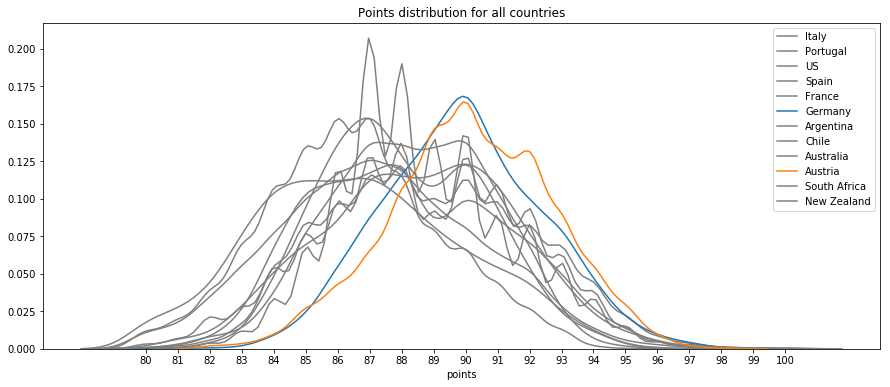

In [3]:
countries = wine_base["country"].unique().tolist()
fig, ax = plt.subplots(figsize = (15, 6))
for c in countries:
    temp = wine_base[wine_base["country"] == c]
    if c != "Austria" and c!="Germany":
        plt.title("Points distribution for all countries")
        ax.set(xticks=wine_base["points"].unique())
        sns.distplot(temp["points"],label=c,hist=False,color="gray")
    else:
        sns.distplot(temp["points"],label=c,hist=False)
        plt.legend()

sns

Here you can see the difference in the distributions, all countries peak around 86/87/88, while germany and austria around 90. This could be why training on them and testing on the others sucks (or vice versa)

In [ ]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fix, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")

    temp = wine_base[wine_base["country"] == c]
    sns.regplot("price","points",data=temp)
    sns
#??

In [ ]:
countries = wine_base["country"].unique().tolist()
for c in countries:
    fig, ax = plt.subplots(figsize = (10, 5))
    temp = wine_base[wine_base["country"] == c]
    plt.title("Price distribution for " + c)
    sns.distplot(temp["price"],hist=True)
    sns

# DEFINE NUMBER OF BINS = classes to be predicted (must be executed so that Y is the same for every execution)

10.0


<module 'seaborn' from 'E:\\Anaconda\\lib\\site-packages\\seaborn\\__init__.py'>

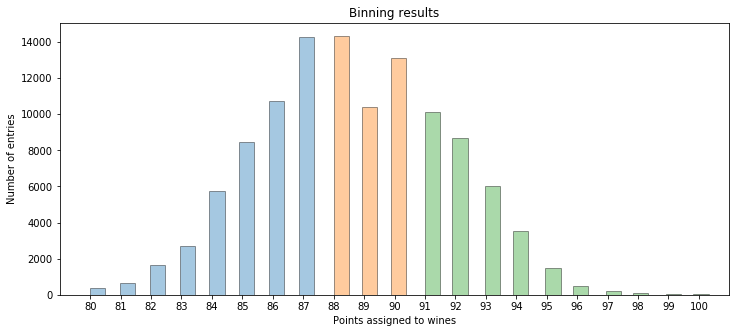

In [4]:
Y = wine_base['points'].copy()
#DECIDE NUMBER OF BINS 
#nbins  = 4
#labels=["low","medium","high","very_high"]
#nbins = 5
#labels=["very_low", "low", "medium","high","very_high"]
#bin identici 
#Y,bins = pd.cut(Y,nbins,labels=labels,retbins=True,include_lowest=True,right=True)
#quartile
nbins  = 3
labels=["low","medium","high"]
Y,bins = pd.qcut(Y,nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
values = Y.tolist()  

#plot the binning result
fig, ax = plt.subplots(figsize = (12, 5))
for i in range(1,len(bins)-1):

    if i == 1:
        a = wine_base[wine_base["points"] <= bins[i]]
        n =  bins[i]-80
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+n
    if i == len(bins)-1:
        a = wine_base[wine_base["points"] > bins[i]]
        n = 100 - bins[i]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
        g =+ n
    else:
        n = bins[i+1] - bins[i]
        g =+n
        a = wine_base[(wine_base["points"] > bins[i]) & (wine_base["points"] <= bins[i+1])]
        sns.distplot(a["points"],hist_kws={"width": 0.5,'edgecolor':'black'},kde=False)
ax.set(xticks=wine_base["points"].unique())
plt.ylabel("Number of entries")
plt.xlabel("Points assigned to wines")
plt.title("Binning results")
print(g)
sns

In [ ]:
basic = ["price",'vintage', 'country', 'province', 'region_1', 'taster_name', 'variety','winery']
word = ["word_count"]
#tfGroup = ['tf_grouped_1','tf_grouped_2', 'tf_grouped_3']
#tfIdfGroup = ['tfIdf_grouped_1', 'tfIdf_grouped_2', 'tfIdf_grouped_3']
#tfFull = ['tf_fullData_1', 'tf_fullData_2', 'tf_fullData_3',]
#tfIdfFull = ['tfIdf_fullData_1', 'tfIdf_fullData_2', 'tfIdf_fullData_3']
#weather = ['pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'tas_5', 'tas_6', 'tas_7', 'tas_8', 'tas_9']# don't really care bcs 0 improvements
word2vec = ['similarityTop3WinesByVariety']
features = basic + word + word2vec

# test on one country, train on the others

In [ ]:
countries = wine_base["country"].unique().tolist()
countries
for c in countries:
    print(c,len(wine_base[wine_base["country"] == c]))
test = wine_base["country"].unique().tolist()

In [ ]:
def testByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest(wine3,el)
        df = df.append(res)
    return df

def applyTest(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    combos = {"depth":[2,3,4,5,6,7,8],"args":[args]}
    #
    res = buildCountryResult(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] != objCountry]
        y_train = pd.DataFrame()
        #obbiettivo è la categoria del dataframe X_train perchè è quello che contiene le righe giuste per le country
        y_train = list(X_train["category"])
        print(objCountry +" must not be in training set " + str(X_train["country"].unique().tolist()))
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] == objCountry]
        y_test = X_test["category"]
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
basic = ["price",'vintage', 'province', 'region_1', 'taster_name', 'variety','winery'] #country non deve esserci 
word = ["word_count"]
word2vec = ['similarityTop3WinesByVariety']
features = []
for el in wine_base.columns:
    if el != "description":
        features.append(el)

result = testByCountry(wine_base,countries)
len(result.columns.tolist())
result.drop("input",inplace=True,axis=1)
result

In [ ]:
#if the column is never used delete it
for col in result.columns:
    if len(result[col].unique().tolist()) == 1 and col != "algorithm":
        result.drop(col,inplace=True,axis=1)
result.columns

In [ ]:
mean = result.groupby("ObjectiveCountry")["precision","accuracy","f1","low_f1","medium_f1","high_f1"].mean()
mean.reset_index(inplace=True)
mean

In [ ]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = mean.sort_values(["f1"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results by testing on each country")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


probably new zealand, italy and US are the least accurate testing because they're theh 

In [ ]:
#plot f1 by category predicted 
temp = mean.sort_values(["medium_f1"],ascending=False)

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (13, 5))

# Create blue bars
begin = plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

end = plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')
xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("f1 by class, by testing model on the single country") 
# Show graphic
plt.show()

In [ ]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 
features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = result.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

In [ ]:
for idx,row in t1.iterrows():
    both = []
    for col in t1.columns:
        if row[col] != 0 and col != "ObjectiveCountry": #and col != "feat_price":    gnore price
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Target country: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features (except price)')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# Train on one test on others

In [ ]:
#wine_base["country_tag"] = wine_base["country"].astype('category').cat.codes
#wine_base.drop("region_1",inplace=True,axis=1)

#this way, the only missing attribute is the country, so that the classifier doesn't work on which country it comes from

In [ ]:
def trainByCountry(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest1(wine3,el)
        df = df.append(res)
    return df

def applyTest1(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
   # print("ARGS " + str(args))
    combos = {"depth":[2,3,4,5,6],"args":[args]}
    #
    res = buildCountryResult1(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult1(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    #print(cols)
    for el in combination["args"]: 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        #print(objCountry +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
        #print(str(X_train["country"].unique().tolist()) + "country in the training set")
        X_train.drop(["country","category"],axis=1,inplace=True)

        X_test = X[X["country"] != objCountry]
        y_test = X_test["category"]
       # print(str(X_test["country"].unique().tolist()) + "country in the test set")
        X_test.drop(["country","category"],axis=1,inplace=True)
        for depth in combination["depth"]:
                row = row + 1  
                #train stuff
                classifier = DecisionTreeClassifier(max_depth=depth)
                classifier.fit(X_train,y_train)
                y_pred = classifier.predict(X_test)  
                acc = accuracy_score(y_test,y_pred)#average="macro")
                weightedPrec = precision_score(y_test,y_pred,average="weighted")
                f1 = f1_score(y_test,y_pred,average="weighted")
                rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth]
                precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                for i in range(0,len(labels)):
                    rowData.append(precision[i])
                    rowData.append(recall[i])
                    rowData.append(fscore[i])
                    rowData.append(support[i])
                    temp = {}
                c = zip(el,classifier.feature_importances_)
                names = []
                for name,importance in c:
                    temp[name] = importance
                    names.append(name)
                for feat in names:
                    #if feat not in allfeatures:
                     #   rowData.append(100) #100 is an impossible value not to be taken into account
                    #else:
                        rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                df2 = pd.DataFrame([rowData],columns=cols)
                results = results.append(df2,ignore_index=True)
        comb = comb + 1
    return results

In [ ]:
trainedOnSingleCountry = trainByCountry(wine_base,countries)
trainedOnSingleCountry.drop("input",inplace=True,axis=1)
trainedOnSingleCountry

#if the column is never used delete it
for col in trainedOnSingleCountry.columns:
    if len(trainedOnSingleCountry[col].unique().tolist()) == 1 and col != "algorithm":
        trainedOnSingleCountry.drop(col,inplace=True,axis=1)
len(trainedOnSingleCountry.columns)

In [ ]:
#plot accuracy, precision, f1 for every country (f1=weighted average of precision, recall)
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","precision","accuracy","f1"]]
temp = temp.sort_values(["f1"],ascending=False)
# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["precision"]
# Choose the height of the cyan bars
bars2 = temp["accuracy"]

bars3 = temp["f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#b2df8a", edgecolor = 'black', capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#1f78b4', edgecolor = 'black', capsize=7, label='accuracy')

plt.bar(r3, bars3, width = barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7, label='f1')

xs = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs)
plt.title("Results obtained by training on a single country and testing on the others")
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
 
# Show graphic
plt.show()


Maybe here us and italy perform better due to the amount of entries on which it has been trained?

In [ ]:

#plot f1 by category predicted 
temp = pd.DataFrame()
temp = df.loc[:,["ObjectiveCountry","low_f1","medium_f1","high_f1"]]
temp = temp.sort_values(["medium_f1","high_f1","low_f1"],ascending=False)
temp

# width of the bars
barWidth = 0.25
 
# Choose the height of the blue bars
bars1 = temp["low_f1"]
# Choose the height of the cyan bars
bars2 = temp["medium_f1"]

bars3 = temp["high_f1"]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
fig, ax = plt.subplots(figsize = (14, 5))

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = "#fee6ce", edgecolor = 'black', capsize=7, label='low')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = '#fdae6b', edgecolor = 'black', capsize=7, label='medium')

plt.bar(r3, bars3, width = barWidth, color = "#e6550d", edgecolor = 'black', capsize=7, label='high')

#ys = temp["ObjectiveCountry"].unique().tolist()
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], xs) #xs definito sopra
plt.ylabel('%')
plt.xlabel("Countries")
plt.legend()
plt.title("Results (f1) obtained by training on a single country and testing on all the others") 
# Show graphic
plt.show()

High class still the most difficoult

In [ ]:
#take mean of all the features used in the computations of decision tree to see the by country and understand which factors play into a country 

features = []
for col in df.columns:
    if col.startswith("feat"):
        features.append(col)
print(features)

t1 = pd.DataFrame()
t = trainedOnSingleCountry.groupby("ObjectiveCountry")
for col in features: 
    t1[col] = t[col].mean() 
t1.reset_index(inplace=True)
t1

In [ ]:
for idx,row in t1.iterrows():
    both = []
    for col in t1.columns:
        if row[col] != 0 and col != "ObjectiveCountry": #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    #print(toPlot)
    #print(values)
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Country on which model has been trained: "+ t1.iloc[idx]["ObjectiveCountry"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

# DUMMY (train one country, test others)

In [ ]:
for c in countries:
    X = wine_base
    wine_base["category"] = Y
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    X_train = X[X["country"] == c]
    y_train = list(X_train["category"])
    print(c +" must be the only one in the training set " + str(X_train["country"].unique().tolist()))
    print(str(X_train["country"].unique().tolist()) + "country in the training set")
    X_train.drop(["country","category"],axis=1,inplace=True)

    X_test = X[X["country"] != c]
    y_test = X_test["category"]
    print(str(X_test["country"].unique().tolist()) + "country in the test set")
    X_test.drop(["country","category"],axis=1,inplace=True)
   
    classifier = DummyClassifier("stratified")
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)  
    acc = accuracy_score(y_test,y_pred)
    weightedPrec = precision_score(y_test,y_pred,average="weighted")
    print("COUNTRY " + c + classification_report(y_test, y_pred, target_names=labels))

    

# DUMMY (country x country)


In [35]:
cols = ["trainedOn","testedOn","f1"]

l = [None] * len(cols)
dummy = pd.DataFrame([l],columns=cols)
for c in countries:
    for c1 in countries:
        if c != c1:
            rowData = [c,c1]
            X = wine_base
            wine_base["category"] = Y
            X_train = X[X["country"] == c]
            y_train = list(X_train["category"])
            X_train.drop(["country","category"],axis=1,inplace=True)

            X_test = X[X["country"] == c1]
            y_test = X_test["category"]
            X_test.drop(["country","category"],axis=1,inplace=True)

            classifier = DummyClassifier("stratified")
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict(X_test)  
            f1 = f1_score(y_test,y_pred,average="weighted")
            rowData.append(f1)
            df2 = pd.DataFrame([rowData],columns=cols)
            dummy = dummy.append(df2)

In [43]:
dummy.reset_index(inplace=True,drop=True)
dummy.sort_values("f1",ascending=False)

,trainedOn,testedOn,f1
3,Argentina,Chile,0.495441
114,Spain,Chile,0.479589
34,Chile,Argentina,0.471912
103,South Africa,Chile,0.452964
111,Spain,Argentina,0.440519
92,Portugal,Chile,0.423496
81,New Zealand,Chile,0.422738
10,Argentina,Spain,0.419939
43,Chile,Spain,0.415890
100,South Africa,Argentina,0.414483


# train on one, test on one

In [24]:
def trainByCountry2(data,countries):
    #for every country, use it as test set
    nbins  = 3
    labels=["low","medium","high"]
    wine2 = pd.DataFrame()
    wine2 = data
    g,b = pd.qcut(data["points"],nbins,labels=labels,retbins=True)   #uses quartiles and statistic stuff
    g.tolist()
    wine3 = wine2.drop(["points"],axis=1)
    wine3["category"] = g
    df = pd.DataFrame()
    for el in countries:
        res = applyTest2(wine3,el)
        df = df.append(res)
    return df

def applyTest2(data,objCountry):
  
    #set many different combinations
    #only on these
    allfeatures = []
    args = []
    for el in wine_base.columns:
        if el != "description":
            allfeatures.append(el)   
        if el != "description" and el != "points" and el != "country":
            args.append(el)
    #just train on price
    #args = ["price"]
    combos = {"depth":[6],"args":[args]}
    #
    res = buildCountryResult2(data,args,allfeatures,combos,objCountry)
    return res

def buildCountryResult2(data,args,allfeatures,combination,objCountry):
    cols = ["algorithm","ObjectiveCountry","input","precision","accuracy","f1","depth","combination","trainedOn","testedOn"]
    algorithm = "decTree"
    for lab in labels:
        cols.append(lab +"_prec")
        cols.append(lab +"_recall")
        cols.append(lab +"_f1")
        cols.append(lab +"_support")
    for el in args: #controlla che allfeats vada bene
        c = "feat_"+el
        if c not in cols:
            cols.append(c)
    results = pd.DataFrame()
    comb = 0
    row = 0
    for el in combination["args"]: 
        countries = data["country"].unique().tolist()
        interestingC =[]
        for gg in countries:
            if gg != objCountry:
                interestingC.append(gg)
      #  countries = countries.remove(objCountry) 
        el = el + ["country","category"]
        X = data[el]
        #create test and training sets
        X_train = X[X["country"] == objCountry]
        y_train = pd.DataFrame()
        y_train = list(X_train["category"])
        X_train.drop(["country","category"],axis=1,inplace=True)

        for countr in interestingC:
            X_test = X[X["country"] == countr]
            y_test = X_test["category"]
            X_test.drop(["country","category"],axis=1,inplace=True)
            for depth in combination["depth"]:
                    row = row + 1  
                    #train stuff
                    classifier = DecisionTreeClassifier(max_depth=depth)
                    classifier.fit(X_train,y_train)
                    y_pred = classifier.predict(X_test)  
                    acc = accuracy_score(y_test,y_pred)#average="macro")
                    weightedPrec = precision_score(y_test,y_pred,average="weighted")
                    f1 = f1_score(y_test,y_pred,average="weighted")
                    nations = objCountry +"->"+countr
                    rowData = [algorithm,objCountry,el,weightedPrec,acc,f1,depth,nations,objCountry,countr]
                    precision,recall,fscore,support = precision_recall_fscore_support(y_test, y_pred)
                    for i in range(0,len(labels)):
                        rowData.append(precision[i])
                        rowData.append(recall[i])
                        rowData.append(fscore[i])
                        rowData.append(support[i])
                        temp = {}
                    c = zip(el,classifier.feature_importances_)
                    names = []
                    for name,importance in c:
                        temp[name] = importance
                        names.append(name)
                    for feat in names:
                        #if feat not in allfeatures:
                         #   rowData.append(100) #100 is an impossible value not to be taken into account
                        #else:
                            rowData.append(temp[feat]) #qualcosa non quadra con le liste di input e colonne per appendere i dataframe con le relative feature importances
                    df2 = pd.DataFrame([rowData],columns=cols)
                    results = results.append(df2,ignore_index=True)
            comb = comb + 1
    return results

In [25]:
twoComb = trainByCountry2(wine_base,countries)
twoComb.drop("input",inplace=True,axis=1)
twoComb

,algorithm,ObjectiveCountry,precision,accuracy,f1,depth,combination,trainedOn,testedOn,low_prec,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,decTree,Argentina,0.576709,0.576186,0.570359,6,Argentina->Italy,Argentina,Italy,0.518178,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,decTree,Argentina,0.590962,0.598586,0.572783,6,Argentina->Portugal,Argentina,Portugal,0.723684,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,decTree,Argentina,0.552182,0.562620,0.549764,6,Argentina->US,Argentina,US,0.647933,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,decTree,Argentina,0.649813,0.658684,0.653411,6,Argentina->Spain,Argentina,Spain,0.628378,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,decTree,Argentina,0.545895,0.541257,0.532364,6,Argentina->France,Argentina,France,0.663212,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,decTree,Argentina,0.600349,0.564712,0.568060,6,Argentina->Germany,Argentina,Germany,0.729647,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,decTree,Argentina,0.723473,0.736956,0.728702,6,Argentina->Chile,Argentina,Chile,0.568807,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,decTree,Argentina,0.561322,0.558685,0.530126,6,Argentina->Australia,Argentina,Australia,0.714286,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,decTree,Argentina,0.527823,0.382510,0.387664,6,Argentina->Austria,Argentina,Austria,0.790861,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,decTree,Argentina,0.604793,0.622274,0.602723,6,Argentina->South Africa,Argentina,South Africa,0.630058,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
temp1 = pd.DataFrame()
feats=[]
for f in twoComb.columns:
    if f != "algorithm" and f != "ObjectiveCountry" and f != "depth":
        feats.append(f)
for f in feats:
    temp1[f] = twoComb[f]
temp1 = temp1.groupby("combination")
t2 =pd.DataFrame()
for col in feats:
    if col != "combination" and col != "trainedOn" and col != "testedOn":
        t2[col] = temp1[col].mean()

t2.reset_index(inplace=True)
t2

,combination,precision,accuracy,f1,low_prec,low_recall,low_f1,low_support,medium_prec,medium_recall,...,feat_Kerin O’Keefe,feat_Lauren Buzzeo,feat_Matt Kettmann,feat_Michael Schachner,feat_Paul Gregutt,feat_Roger Voss,feat_Sean P. Sullivan,feat_Susan Kostrzewa,feat_Virginie Boone,feat_unknown
0,Argentina->Australia,0.561322,0.558685,0.530126,0.714286,0.472509,0.568769,582,0.548287,0.893401,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Argentina->Austria,0.527823,0.382510,0.387664,0.790861,0.341426,0.476948,1318,0.251485,0.881944,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Argentina->Chile,0.723473,0.736956,0.728702,0.568807,0.548673,0.558559,339,0.822297,0.876170,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Argentina->France,0.545895,0.541257,0.532364,0.663212,0.451310,0.537117,5956,0.584993,0.774846,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Argentina->Germany,0.600349,0.564712,0.568060,0.729647,0.626649,0.674237,758,0.394453,0.744186,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Argentina->Italy,0.576709,0.576186,0.570359,0.518178,0.689698,0.591760,4009,0.651410,0.672126,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Argentina->New Zealand,0.517565,0.509464,0.465586,0.643939,0.330739,0.437018,257,0.500571,0.895706,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Argentina->Portugal,0.590962,0.598586,0.572783,0.723684,0.440352,0.547536,1249,0.628339,0.896792,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Argentina->South Africa,0.604793,0.622274,0.602723,0.630058,0.471861,0.539604,231,0.676316,0.872666,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Argentina->Spain,0.649813,0.658684,0.653411,0.628378,0.603243,0.615554,925,0.751852,0.801843,...,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


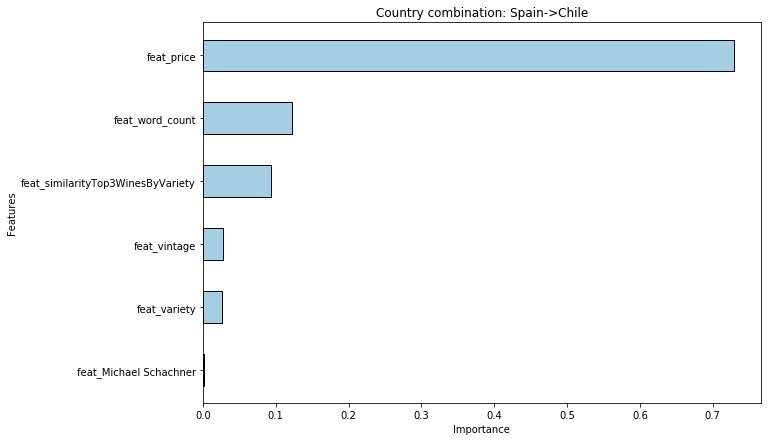

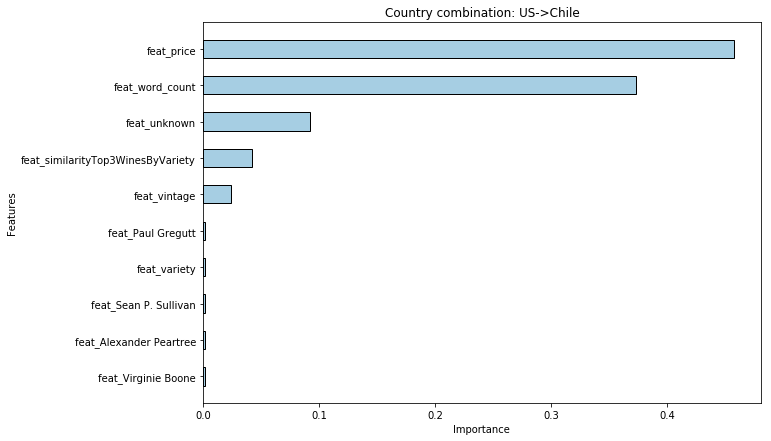

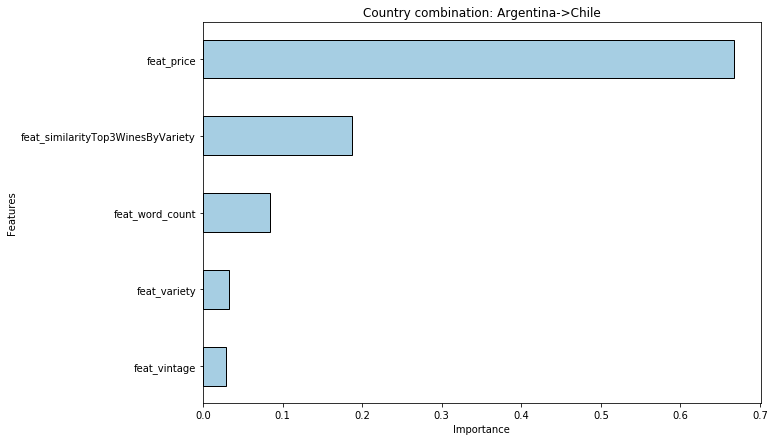

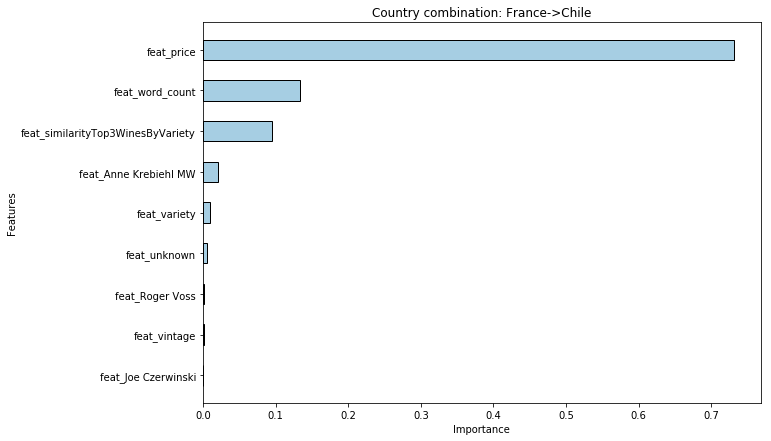

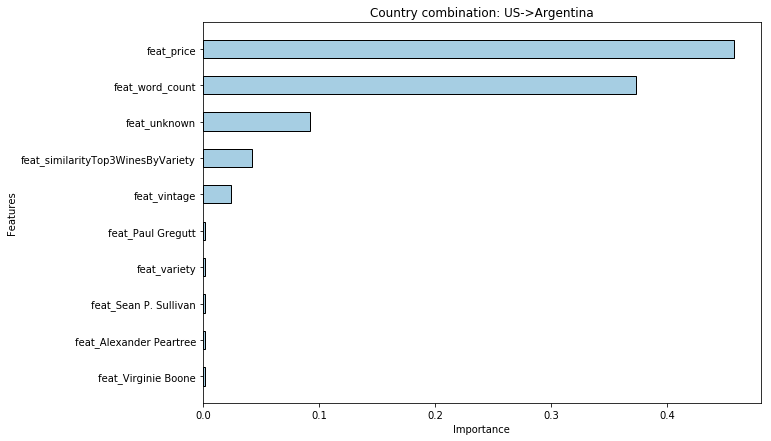

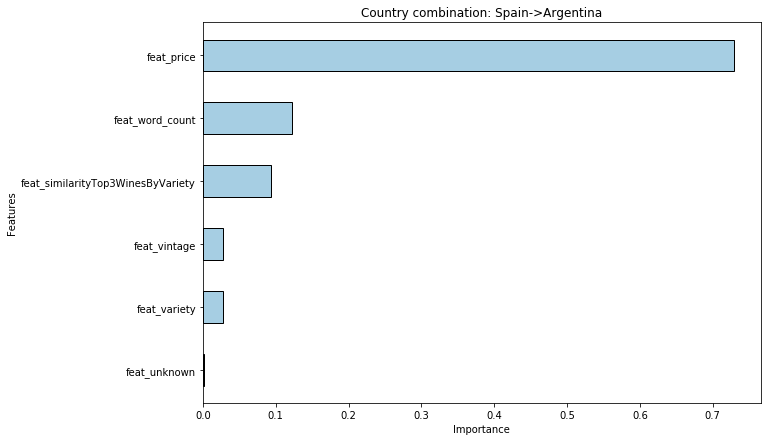

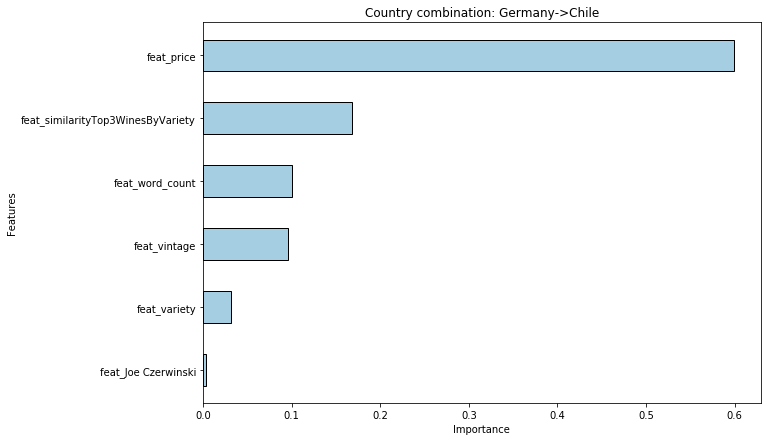

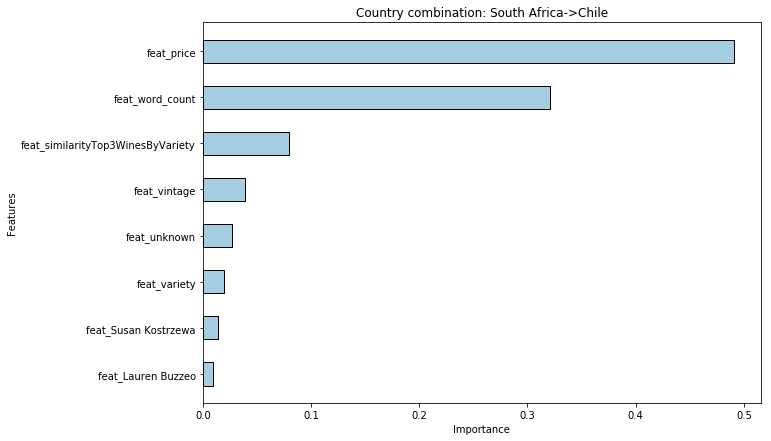

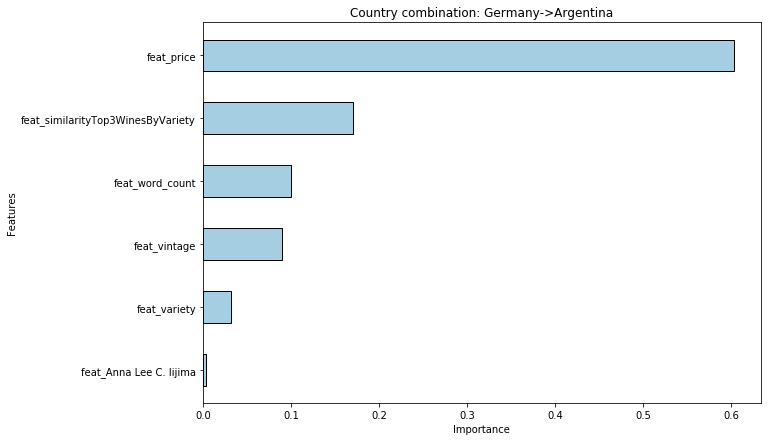

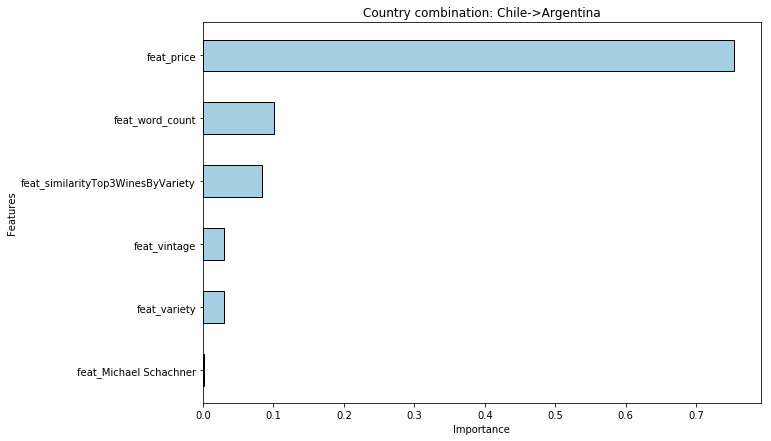

In [27]:
temp = t2
temp = temp.sort_values(["f1"],ascending=False)
temp = temp.head(10)
for idx,row in temp.iterrows():
    both = []
    for col in temp.columns:
        if row[col] != 0 and col != "combination" and col.startswith("feat"): #THIS TAKES INTO ACCOUNT EVEN PRICE WHICH IS A LOT LESS IMPORTANT COMPARED TO THE FIRST APPROACH
            both.append([col,row[col]])
    
    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    
    toPlot = []
    values = []    
    for el in both:
        toPlot.append(el[0])
        values.append(el[1])
    
    # width of the bars
    barWidth = 0.5
    
    # Choose the height of the blue bars
    bars1 = values

    # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

    # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
    #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
    # general layout
    #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
    #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Country combination: "+ row["combination"])
    plt.ylabel('Features')
    plt.xlabel("Importance")
    # Show graphic
    plt.show()

(media fra i risultati e li normalizzi) divide every mean obtained on germany by the mean of germany. Look at the average f1 by target country, if it's higher than 64/65, indaga perchè è più alto del 65 ottenuto con 70% train 30% test

# Nation to nation heatmap

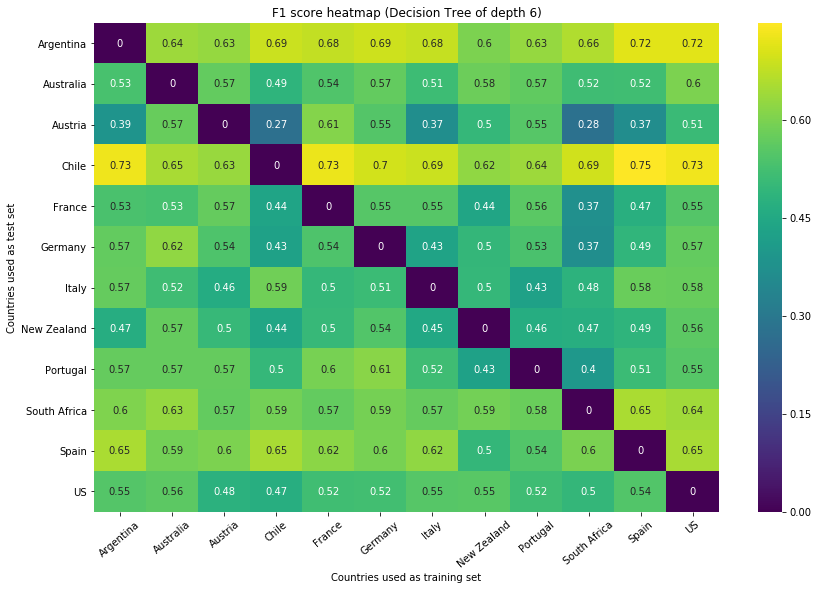

[ 80.  87.  90. 100.]


In [29]:
temp1 = pd.DataFrame()
feats=["trainedOn","testedOn","f1"]
for f in feats:
    temp1[f] = twoComb[f]
temp1 = temp1.groupby(["trainedOn","testedOn"])
t2 =pd.DataFrame()
for col in feats:
    if col != "combination" and col != "trainedOn" and col != "testedOn":
        t2[col] = temp1[col].mean()
t2.reset_index(inplace=True)
#t2.sort_values("f1",ascending=False)
columns = ["trainedOn"]
countries = t2["trainedOn"].unique().tolist() #it's also the order
for c in countries:
    columns.append(c)
heatDf = pd.DataFrame(columns = columns)
l = [None] * len(columns)
for trained in countries:
    test = t2[t2["trainedOn"] == trained]
    df2 = pd.DataFrame([l],columns=columns).fillna(0.0)
    df2["trainedOn"] = trained
    for idx,row in test.iterrows():
        df2[row["testedOn"]] = row["f1"]
    heatDf = heatDf.append(df2)
heatDf.reset_index(drop=True,inplace=True)

#plot heatmap
Index= countries
Cols = countries
df = pd.DataFrame(heatDf.drop("trainedOn",axis=1).transpose().values, index=Index, columns=Cols)
fig, ax = plt.subplots(figsize = (14, 9))

sns.heatmap(df, annot=True,cmap="viridis")
plt.title("F1 score heatmap (Decision Tree of depth 6)")
plt.ylabel("Countries used as test set")
plt.xlabel("Countries used as training set")
plt.xticks(rotation=40)
plt.show()
print(bins)

Prendi i risultati del dummy classifier e comparali con questi, magari mostra la differenza

In [10]:
for c in countries:
    ada = wine_base[wine_base["country"] == c]
    
    if (87 <= ada["points"].mean() <= 90 ):
        print(c + " has the mean points value in the medium bin")
    else: 
        print(c + " not in the medium " + str(ada["points"].mean()))

Argentina not in the medium 86.68183118741058
Australia has the mean points value in the medium bin
Austria not in the medium 90.14919893190921
Chile not in the medium 86.47174801635009
France has the mean points value in the medium bin
Germany has the mean points value in the medium bin
Italy has the mean points value in the medium bin
New Zealand has the mean points value in the medium bin
Portugal has the mean points value in the medium bin
South Africa has the mean points value in the medium bin
Spain has the mean points value in the medium bin
US has the mean points value in the medium bin


if you plot the heatmap based only on price, you see the results are worse and slightly worse. If the training set's points distribution is in the medium bin, values will be higher and if the distributions are similar, the result will be better.
If the distribution is not in the medium bin but the pts distr is similar (austria-> germany) you'll get a high value?


by using only price, austria sucks across the board, there you really can see the improvement in the prediction with the other features

[['Austria', 0.7570230299410028], ['New Zealand', 0.828813182004182], ['US', 0.9341809998915798], ['France', 0.9661226431498827], ['Australia', 0.9685636713859886], ['Germany', 0.9980156472373535], ['Italy', 0.9995023047876269], ['Portugal', 1.0220432282953764], ['South Africa', 1.0620881143912708], ['Spain', 1.1743260249929635], ['Chile', 1.289321153922777]]


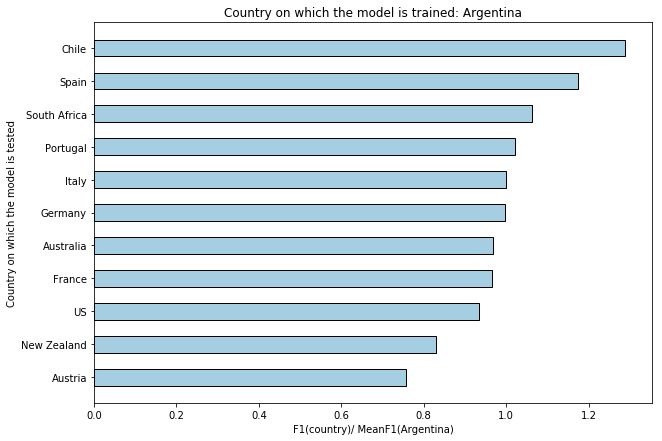

[['Italy', 0.8433981394877368], ['US', 0.8859305474814672], ['France', 0.9240785054437648], ['New Zealand', 0.9245606651382824], ['Austria', 0.9918559477128419], ['Spain', 1.016479132871965], ['Portugal', 1.04154964319582], ['Germany', 1.0672732666187936], ['South Africa', 1.0748085983746278], ['Argentina', 1.0988204432166888], ['Chile', 1.1312451104580157]]


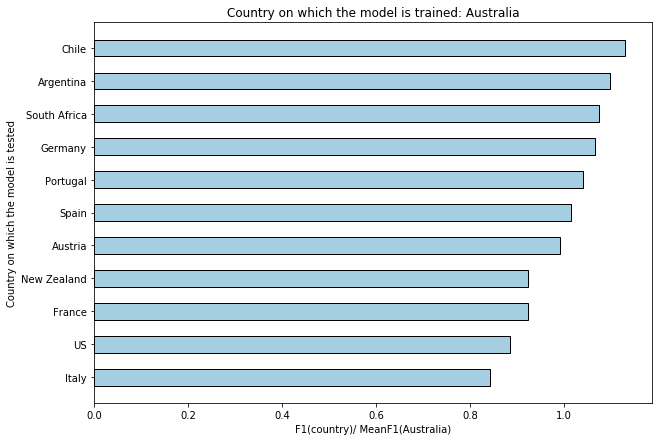

[['Italy', 0.8629738421042424], ['US', 0.895802042590909], ['New Zealand', 0.9093963904697866], ['South Africa', 0.9486420703594228], ['Australia', 1.026179928514303], ['Spain', 1.0318267572781512], ['Portugal', 1.0511883484731859], ['Germany', 1.0601726721325302], ['Chile', 1.0633851180415592], ['Argentina', 1.0717712780431947], ['France', 1.0786615519927172]]


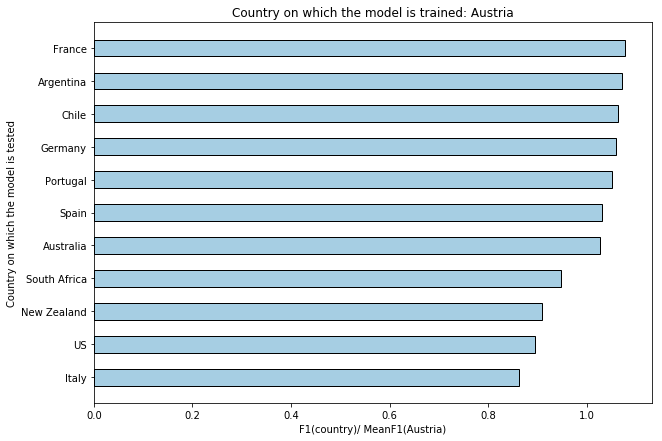

[['Austria', 0.5957249756946759], ['Germany', 0.8042880700428842], ['New Zealand', 0.8840802650587487], ['Portugal', 0.9354513430162322], ['US', 0.9509230035124098], ['France', 0.9770302081269705], ['Australia', 0.9927692904964498], ['Italy', 1.1006606282563547], ['South Africa', 1.1571642831102067], ['Spain', 1.2464834188748972], ['Argentina', 1.3554245138101693]]


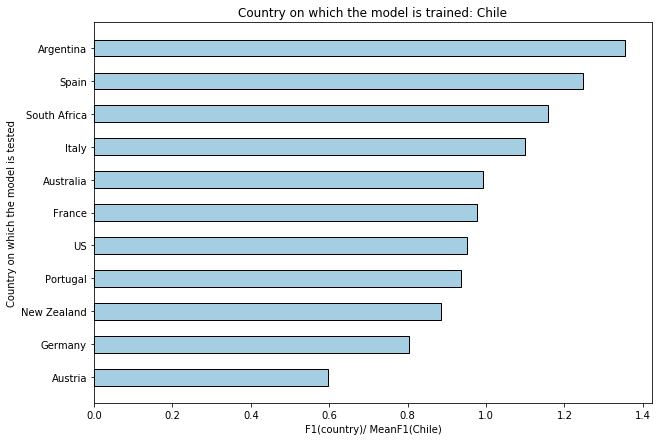

[['New Zealand', 0.8699894024370867], ['Italy', 0.8727122495709158], ['US', 0.894129968659208], ['Austria', 0.9364392309454136], ['Germany', 0.9548397212211448], ['Australia', 0.9747746713514064], ['Portugal', 1.018465538742559], ['South Africa', 1.0235707379821672], ['Spain', 1.077021573241422], ['Argentina', 1.155219993920945], ['Chile', 1.2228369119277318]]


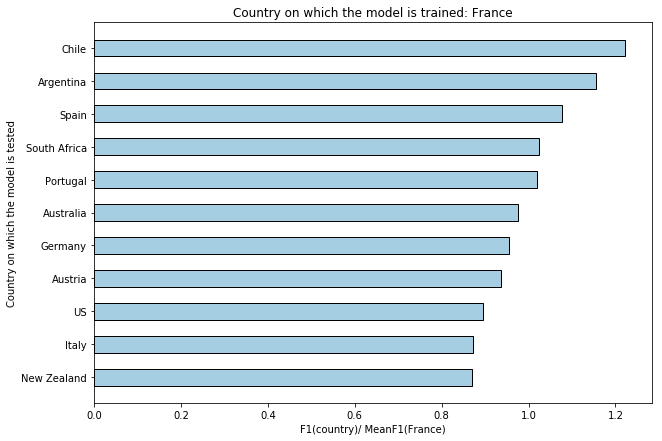

[['Italy', 0.8723125128323717], ['US', 0.8878065404459404], ['New Zealand', 0.9516509770354308], ['Spain', 0.969169224660856], ['France', 0.9861236636211581], ['Australia', 1.0016234680953822], ['South Africa', 1.0224917929128219], ['Austria', 1.0514405940284763], ['Portugal', 1.081147318029651], ['Argentina', 1.086366381776413], ['Chile', 1.089867526561502]]


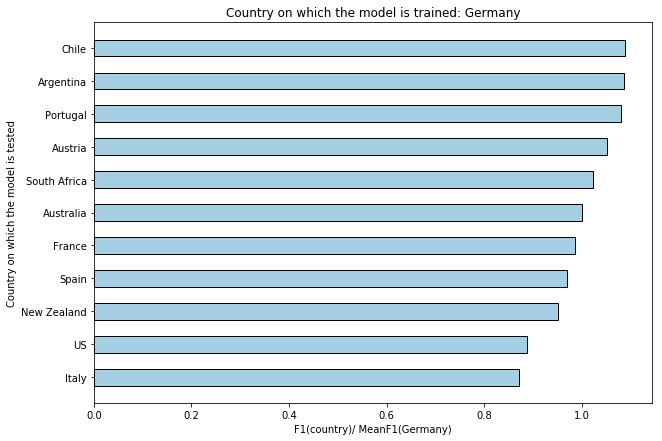

[['Austria', 0.6761285326301549], ['Germany', 0.7592547333705258], ['New Zealand', 0.8655686106655229], ['Portugal', 0.9181914982183295], ['France', 0.95668806244399], ['Australia', 0.9668737633790806], ['US', 1.0047777142026948], ['South Africa', 1.077964221177482], ['Spain', 1.1771131551144112], ['Argentina', 1.281588326202969], ['Chile', 1.31585138259484]]


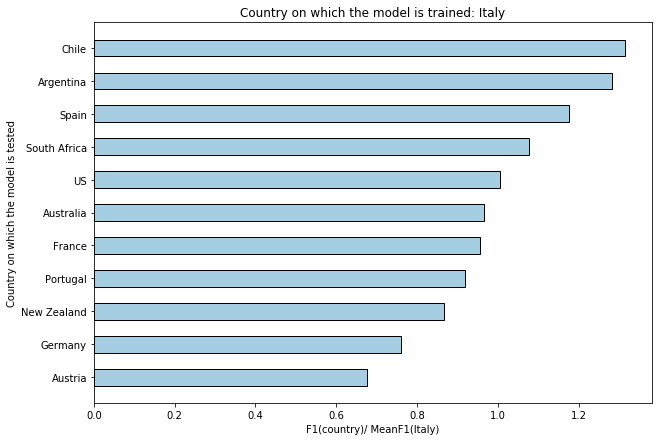

[['Portugal', 0.9284950612677465], ['France', 0.934383995590428], ['Spain', 0.9526512835963474], ['Italy', 0.952870374524641], ['Austria', 0.9856745069975763], ['Chile', 1.0018870185468054], ['Germany', 1.0206814405333178], ['South Africa', 1.0342032823240754], ['US', 1.0448382637736573], ['Argentina', 1.0589337789272184], ['Australia', 1.085380993918191]]


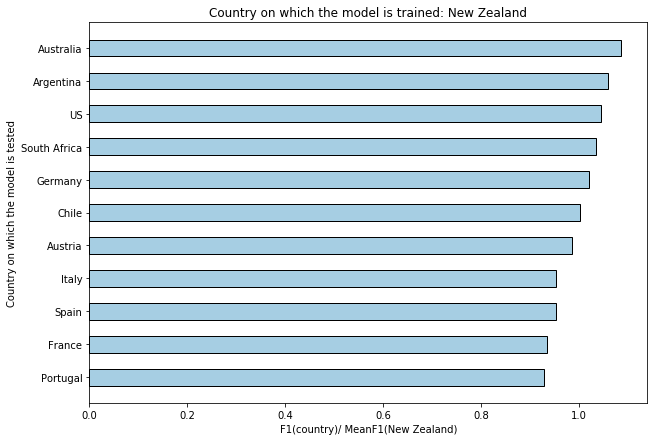

[['New Zealand', 0.847285249560329], ['Italy', 0.8616163315160777], ['US', 0.9107860826250637], ['Austria', 0.9386018276799836], ['Germany', 1.0052730154547715], ['Australia', 1.008622873537989], ['South Africa', 1.009575699753318], ['France', 1.0188138263679123], ['Spain', 1.0330227481224235], ['Argentina', 1.1791605647855743], ['Chile', 1.1872417805965547]]


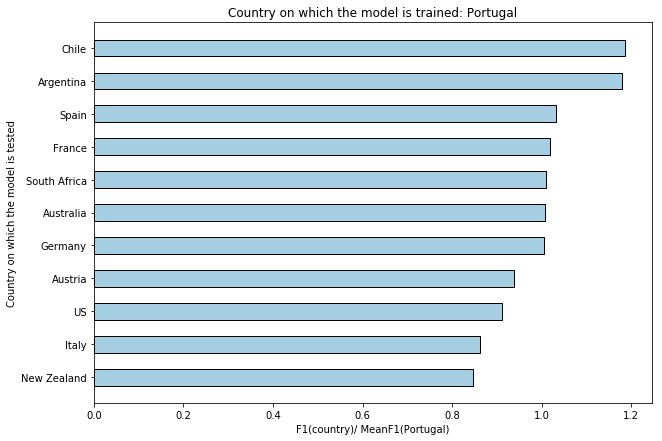

[['Austria', 0.5323862041984123], ['Germany', 0.6208135081109488], ['France', 0.7205441945370784], ['Portugal', 0.84072543029467], ['US', 0.9411271515786157], ['New Zealand', 0.9578788705745406], ['Australia', 0.9834727457748438], ['Italy', 1.015725386917324], ['Spain', 1.3281325314770107], ['Argentina', 1.4500729354441846], ['Chile', 1.6091210410923689]]


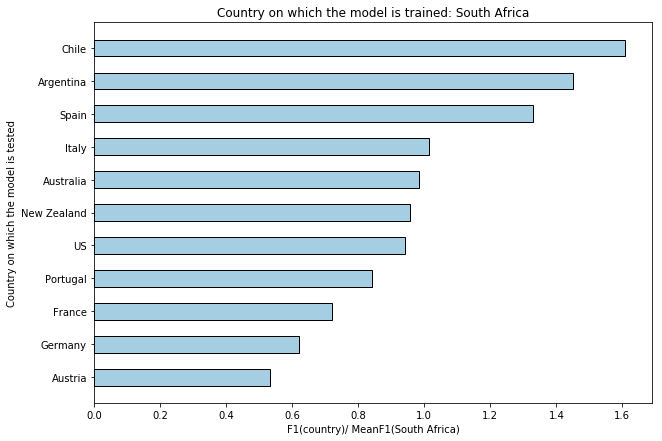

[['Austria', 0.7058491576754048], ['Germany', 0.8636050183197862], ['New Zealand', 0.8932083327106498], ['France', 0.9305694407615858], ['Portugal', 0.9309093799372389], ['Australia', 0.9549379213223891], ['US', 0.9628018427102897], ['Italy', 1.0307644627215653], ['South Africa', 1.1368385731724], ['Argentina', 1.2644177784303177], ['Chile', 1.3260980922383732]]


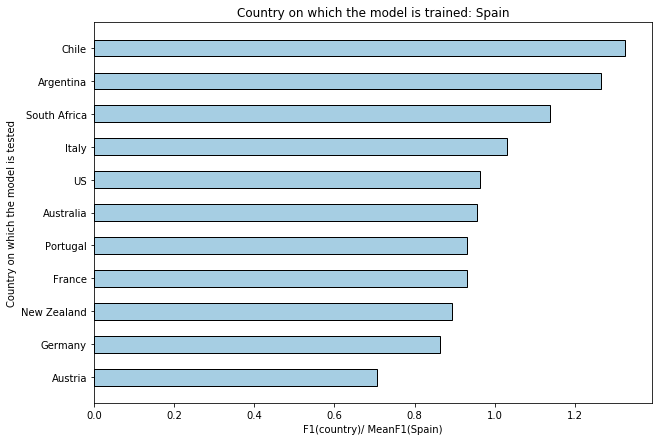

[['Austria', 0.8891042351437142], ['France', 0.93786461444934], ['Portugal', 0.954478924309612], ['Germany', 0.96514513335142], ['New Zealand', 0.9879655250819303], ['Italy', 0.9880229516334958], ['South Africa', 1.0247401036455426], ['Spain', 1.0364528996443607], ['Australia', 1.0492088762921978], ['Chile', 1.0707311392227954], ['Argentina', 1.0962855972255892]]


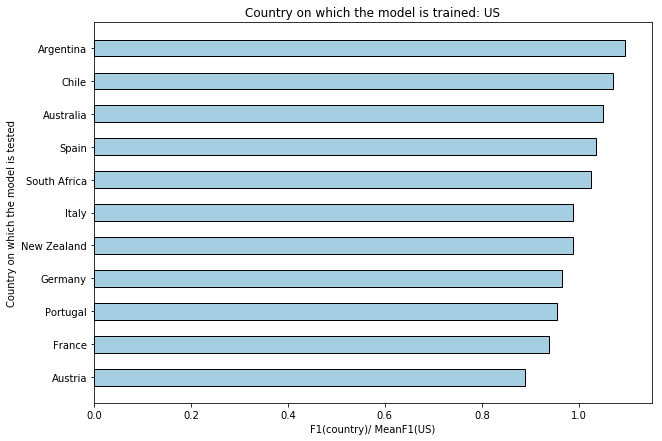

In [11]:
meanTrainF1 = twoComb.groupby("trainedOn")["f1"].mean()
meanTrainF1
#in this case, i divide Argentina (train) -> Spain (test)'s F1 by the mean F1 obtained from Argentina -> everything else
#if it's more than one, than the results on that country are above the average
countries = t2["trainedOn"].unique().tolist()
for trainedOn in countries:
    data = t2[t2["trainedOn"] == trainedOn]
    both = []
    for idx,row in data.iterrows():
        both.append([row["testedOn"], row["f1"]/meanTrainF1[trainedOn]])
        #print(toPlot)
        #print(values)

    from operator import itemgetter
    both = sorted(both, key=itemgetter(1))
    print(both)

    toPlot = []
    values = []    
    for el in both:
            toPlot.append(el[0])
            values.append(el[1])

            # width of the bars
    barWidth = 0.5

            # Choose the height of the blue bars
    bars1 = values

            # The x position of bars
    r1 = np.arange(len(toPlot))
    fig, ax = plt.subplots(figsize = (10, 7))

            # Create blue bars
    plt.barh(r1, bars1, height=barWidth, color = "#a6cee3", edgecolor = 'black', capsize=7)
           #plt.bar(r1,bars1,width = barWidth..)
    ys = toPlot
            # general layout
            #plt.xticks([r for r in range(len(bars1))], ys,rotation='vertical')
            #plt.yticks([r for r in range(len(bars1))], ys,rotation='vertical')
    plt.yticks([r for r in range(len(bars1))], ys)
    plt.title("Country on which the model is trained: " +trainedOn)
    plt.ylabel('Country on which the model is tested')
    plt.xlabel("F1(country)/ MeanF1(" + trainedOn+")")
            # Show graphic
    plt.show()

In [12]:
meanTrainF1 = twoComb.groupby("trainedOn")["f1"].mean()
meanTrainF1


trainedOn
Argentina       0.552361
Australia       0.576351
Austria         0.485255
Chile           0.513569
France          0.580845
Germany         0.504446
Italy           0.524986
New Zealand     0.524840
Portugal        0.548179
South Africa    0.443183
Spain           0.557412
US              0.548463
Name: f1, dtype: float64

austria mean points  90.14919893190921
australia mean points 88.56197183098591
[ 80.  87.  90. 100.]


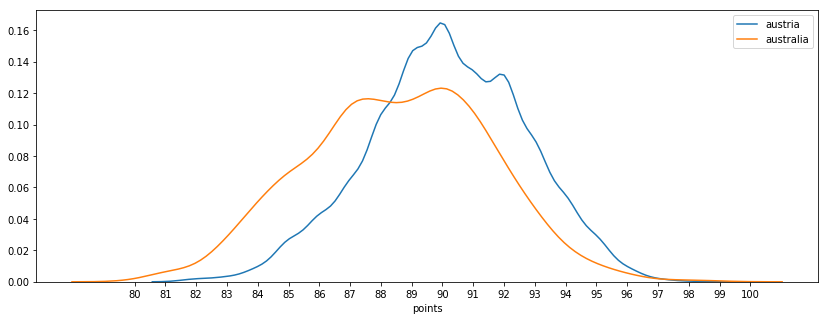

In [13]:
fig, ax = plt.subplots(figsize = (14, 5))
ax.set(xticks=wine_base["points"].unique())
temp = wine_base[(wine_base["country"] == "Austria")]
sns.distplot(temp["points"],label="austria",bins = 20,hist=False,norm_hist=False,kde=True)
print("austria mean points ",temp["points"].mean())
temp = wine_base[(wine_base["country"] == "Australia")]
sns.distplot(temp["points"],label="australia",bins = 20,hist=False,norm_hist=False,kde=True)
print("australia mean points",temp["points"].mean())
print(bins)

if u look at the plot below, no difference between chile/argentina and argentina/chile because points distributions are very similar

it seems that the closest the training set to the mean points in the dataset, the better result on any test set

chile's mean is not in the medium, so this is pretty much confirmed (italyy is in the medium):

there is a problem: if you train on chile and test on italy 56, if you train on italy and test on chile 69.

Check the medium bin f1

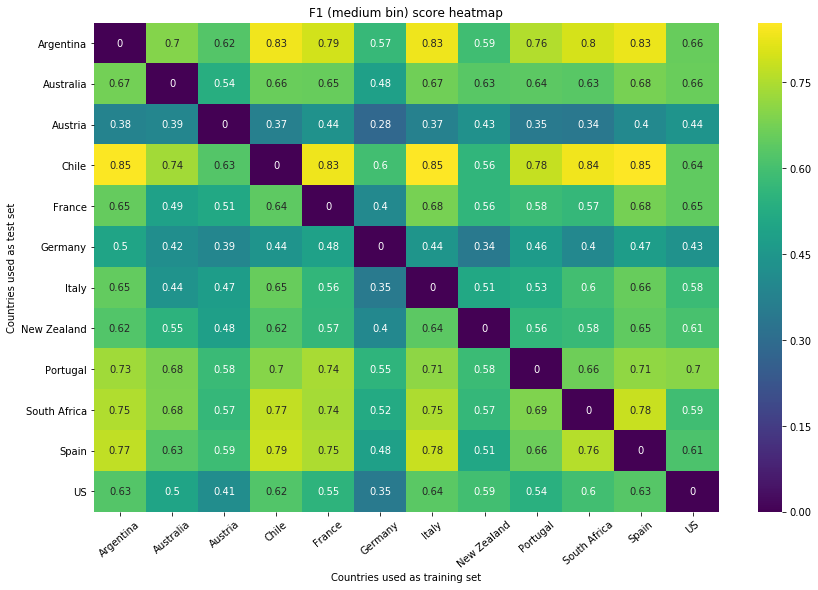

In [14]:
temp1 = pd.DataFrame()
feats=["trainedOn","testedOn","medium_f1"]
for f in feats:
    temp1[f] = twoComb[f]
temp1 = temp1.groupby(["trainedOn","testedOn"])
t2 =pd.DataFrame()
for col in feats:
    if col != "combination" and col != "trainedOn" and col != "testedOn":
        t2[col] = temp1[col].mean()
t2.reset_index(inplace=True)
#t2.sort_values("f1",ascending=False)
columns = ["trainedOn"]
countries = t2["trainedOn"].unique().tolist() #it's also the order
for c in countries:
    columns.append(c)
heatDf = pd.DataFrame(columns = columns)
l = [None] * len(columns)
for trained in countries:
    test = t2[t2["trainedOn"] == trained]
    df2 = pd.DataFrame([l],columns=columns).fillna(0.0)
    df2["trainedOn"] = trained
    for idx,row in test.iterrows():
        df2[row["testedOn"]] = row["medium_f1"]
    heatDf = heatDf.append(df2)
heatDf.reset_index(drop=True,inplace=True)

#plot heatmap
Index= countries
Cols = countries
df = pd.DataFrame(heatDf.drop("trainedOn",axis=1).transpose().values, index=Index, columns=Cols)
fig, ax = plt.subplots(figsize = (14, 9))

sns.heatmap(df, annot=True,cmap="viridis")
plt.title("F1 (medium bin) score heatmap")
plt.ylabel("Countries used as test set")
plt.xlabel("Countries used as training set")
plt.xticks(rotation=40)
plt.show()


In [ ]:
t2

# check why chile some countries are easier to predict / austria and germany suck

--------RESULTS OF-------Chile Argentina: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
33     Chile  Argentina   0.834548
   trainedOn testedOn  medium_f1
2  Argentina    Chile   0.847603


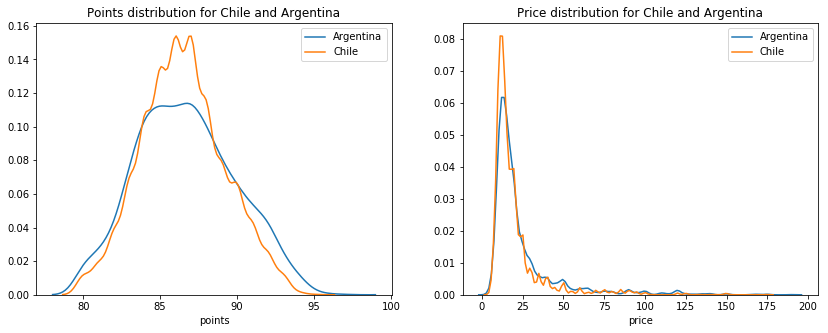

--------RESULTS OF-------Austria Argentina: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
22   Austria  Argentina   0.624998
   trainedOn testedOn  medium_f1
1  Argentina  Austria   0.380517


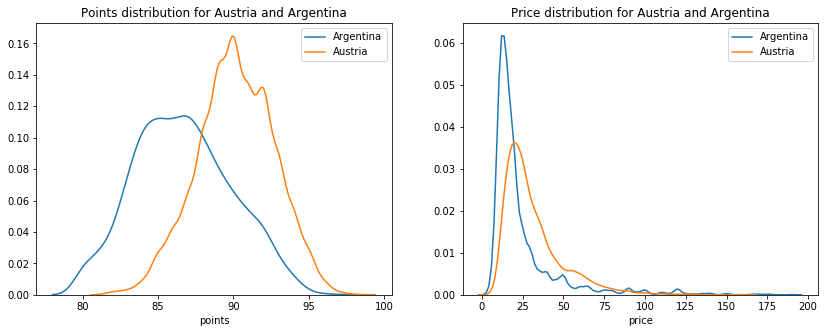

--------RESULTS OF-------Germany Argentina: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
55   Germany  Argentina   0.571587
   trainedOn testedOn  medium_f1
4  Argentina  Germany   0.498824


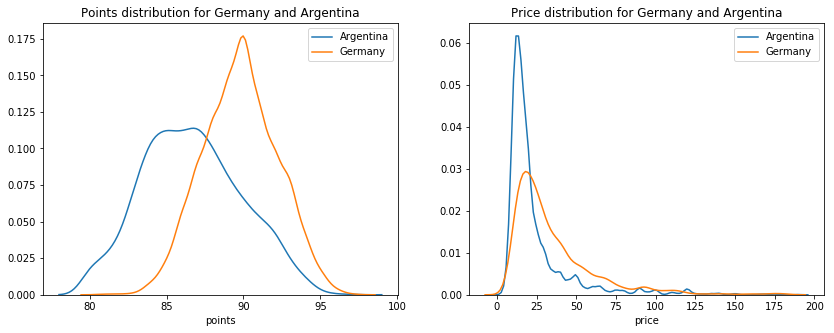

--------RESULTS OF-------Chile Australia: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
34     Chile  Australia   0.658777
    trainedOn testedOn  medium_f1
13  Australia    Chile   0.736246


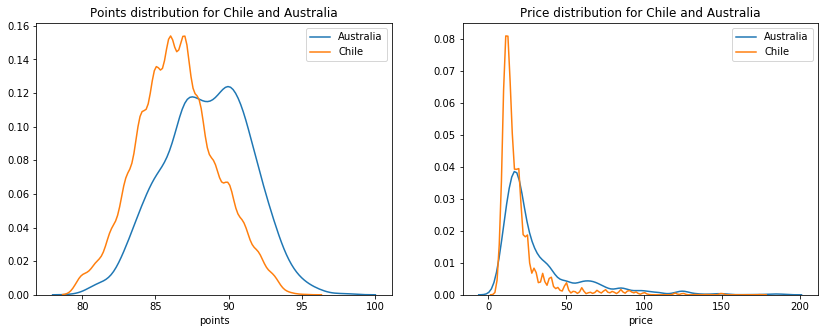

--------RESULTS OF-------Argentina Australia: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
0  Argentina  Australia   0.670865
    trainedOn   testedOn  medium_f1
11  Australia  Argentina   0.696432


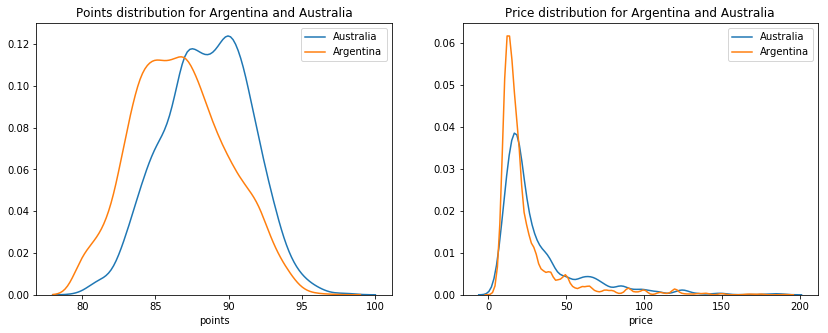

--------RESULTS OF-------Austria Australia: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
23   Austria  Australia   0.535188
    trainedOn testedOn  medium_f1
12  Australia  Austria   0.392294


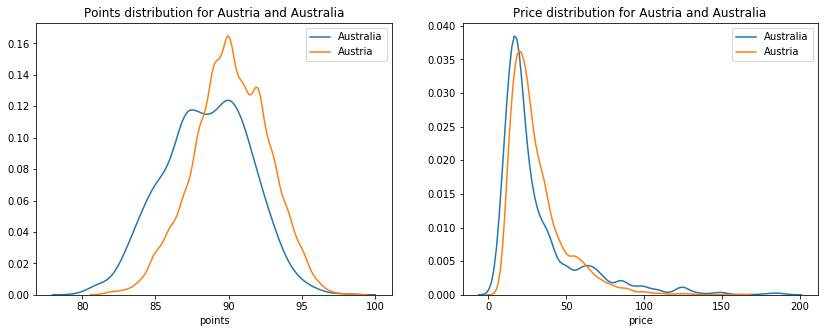

--------RESULTS OF-------Germany Australia: (trained/tested) f1 
   trainedOn   testedOn  medium_f1
56   Germany  Australia   0.481454
    trainedOn testedOn  medium_f1
15  Australia  Germany   0.417086


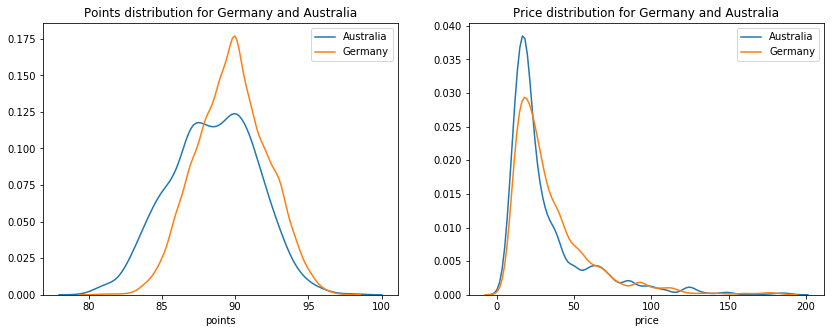

--------RESULTS OF-------Chile Austria: (trained/tested) f1 
   trainedOn testedOn  medium_f1
35     Chile  Austria   0.369992
   trainedOn testedOn  medium_f1
24   Austria    Chile   0.625078


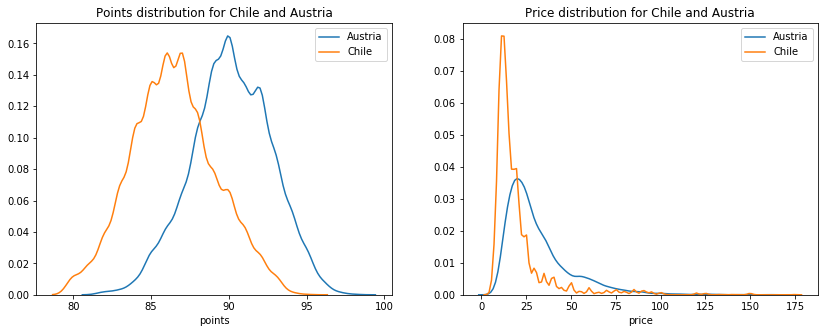

--------RESULTS OF-------Argentina Austria: (trained/tested) f1 
   trainedOn testedOn  medium_f1
1  Argentina  Austria   0.380517
   trainedOn   testedOn  medium_f1
22   Austria  Argentina   0.624998


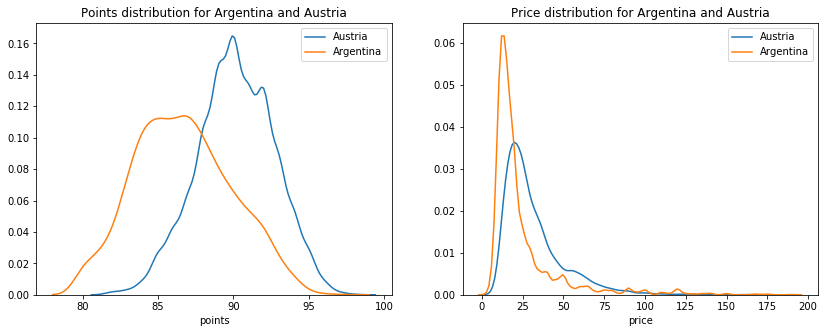

--------RESULTS OF-------Germany Austria: (trained/tested) f1 
   trainedOn testedOn  medium_f1
57   Germany  Austria   0.284537
   trainedOn testedOn  medium_f1
26   Austria  Germany    0.39059


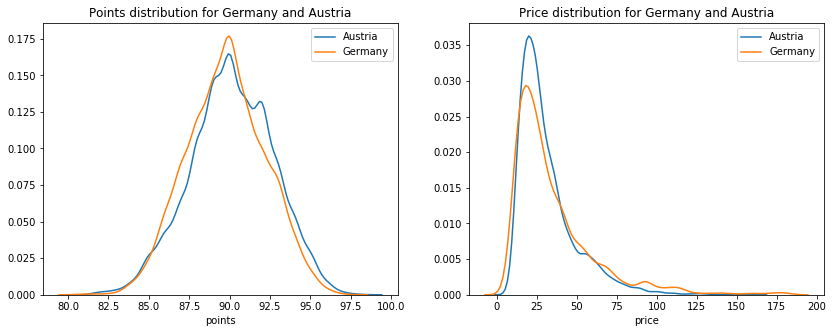

--------RESULTS OF-------Argentina Chile: (trained/tested) f1 
   trainedOn testedOn  medium_f1
2  Argentina    Chile   0.847603
   trainedOn   testedOn  medium_f1
33     Chile  Argentina   0.834548


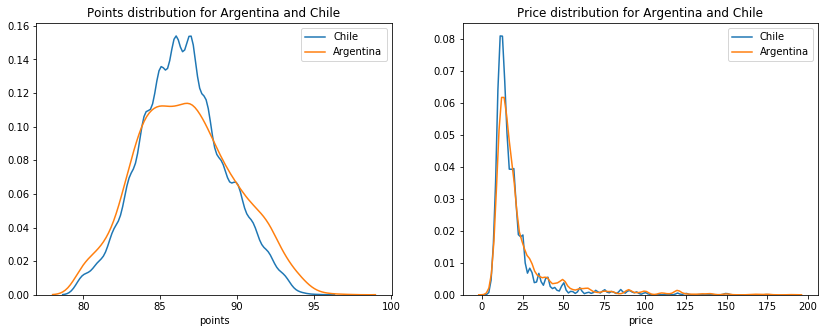

--------RESULTS OF-------Austria Chile: (trained/tested) f1 
   trainedOn testedOn  medium_f1
24   Austria    Chile   0.625078
   trainedOn testedOn  medium_f1
35     Chile  Austria   0.369992


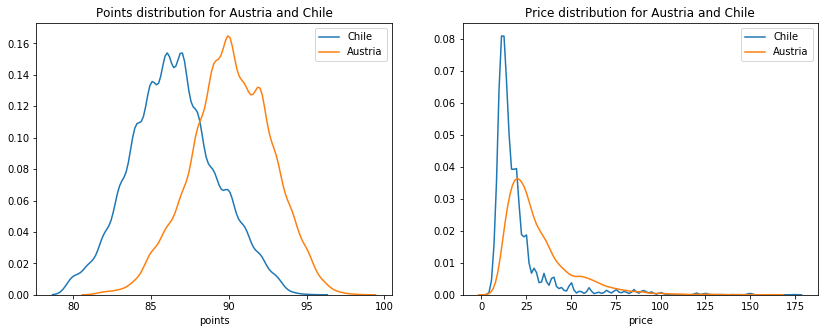

--------RESULTS OF-------Germany Chile: (trained/tested) f1 
   trainedOn testedOn  medium_f1
58   Germany    Chile   0.596889
   trainedOn testedOn  medium_f1
37     Chile  Germany   0.441348


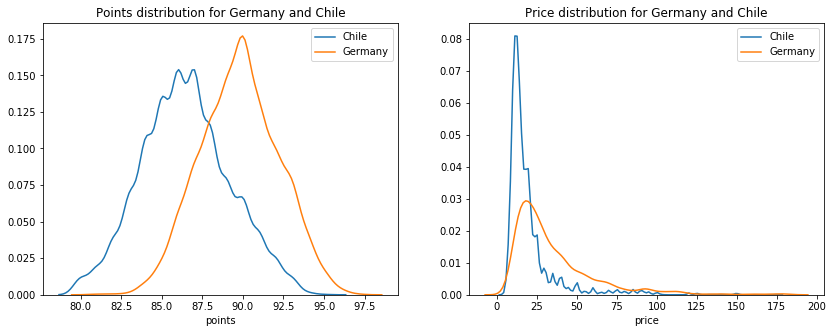

--------RESULTS OF-------Chile France: (trained/tested) f1 
   trainedOn testedOn  medium_f1
36     Chile   France   0.643036
   trainedOn testedOn  medium_f1
47    France    Chile    0.83371


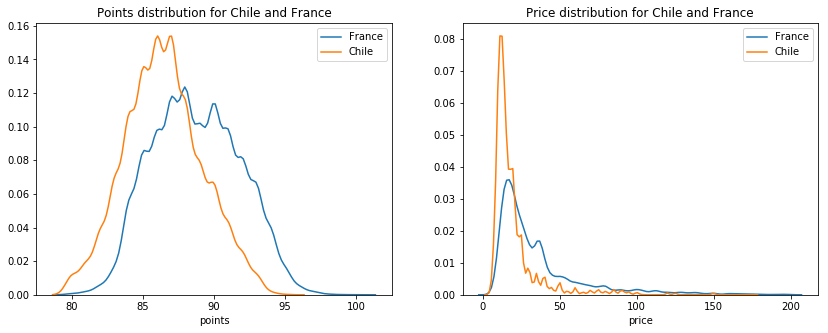

--------RESULTS OF-------Argentina France: (trained/tested) f1 
   trainedOn testedOn  medium_f1
3  Argentina   France   0.650964
   trainedOn   testedOn  medium_f1
44    France  Argentina   0.794601


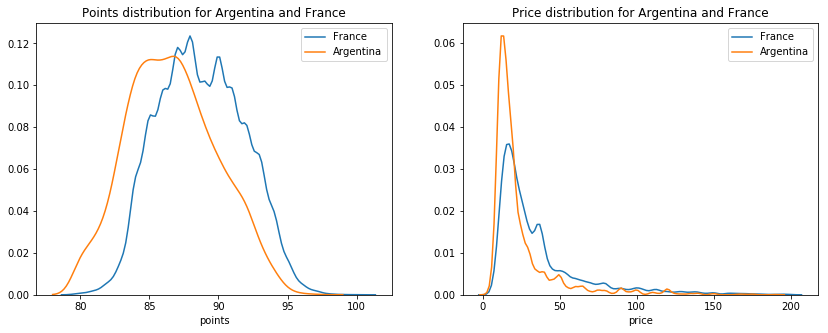

--------RESULTS OF-------Austria France: (trained/tested) f1 
   trainedOn testedOn  medium_f1
25   Austria   France   0.511936
   trainedOn testedOn  medium_f1
46    France  Austria   0.435242


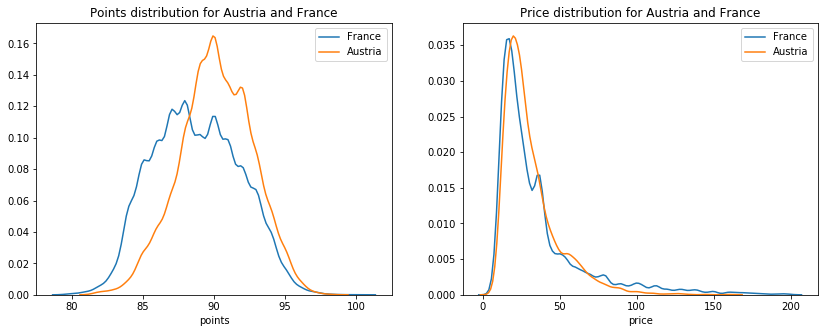

--------RESULTS OF-------Germany France: (trained/tested) f1 
   trainedOn testedOn  medium_f1
59   Germany   France    0.40309
   trainedOn testedOn  medium_f1
48    France  Germany   0.484555


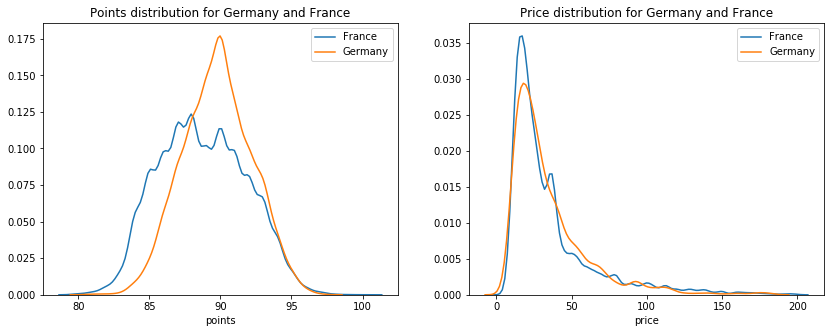

--------RESULTS OF-------Chile Germany: (trained/tested) f1 
   trainedOn testedOn  medium_f1
37     Chile  Germany   0.441348
   trainedOn testedOn  medium_f1
58   Germany    Chile   0.596889


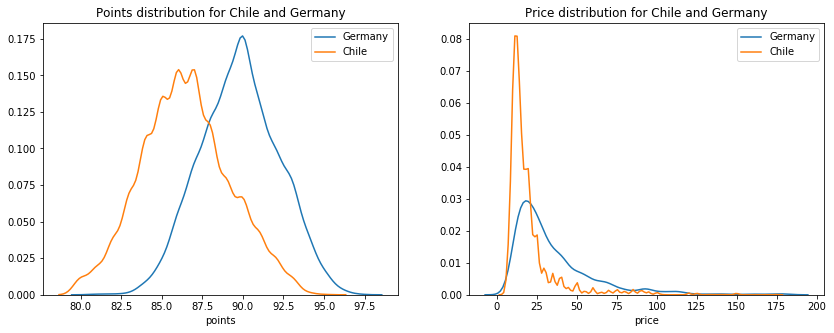

--------RESULTS OF-------Argentina Germany: (trained/tested) f1 
   trainedOn testedOn  medium_f1
4  Argentina  Germany   0.498824
   trainedOn   testedOn  medium_f1
55   Germany  Argentina   0.571587


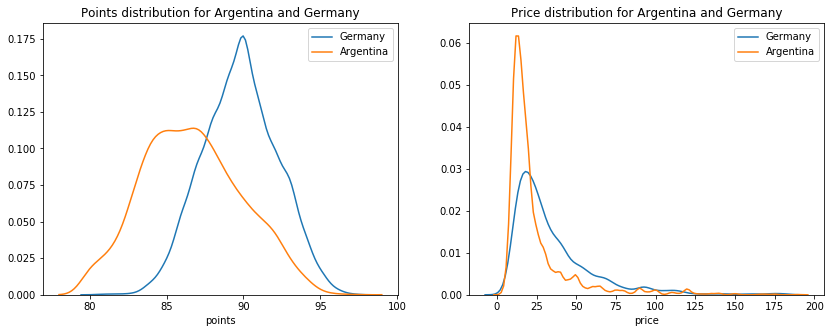

--------RESULTS OF-------Austria Germany: (trained/tested) f1 
   trainedOn testedOn  medium_f1
26   Austria  Germany    0.39059
   trainedOn testedOn  medium_f1
57   Germany  Austria   0.284537


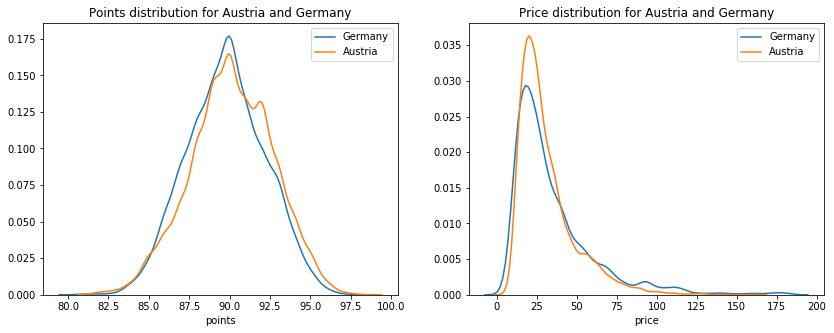

--------RESULTS OF-------Chile Italy: (trained/tested) f1 
   trainedOn testedOn  medium_f1
38     Chile    Italy   0.654114
   trainedOn testedOn  medium_f1
69     Italy    Chile   0.850893


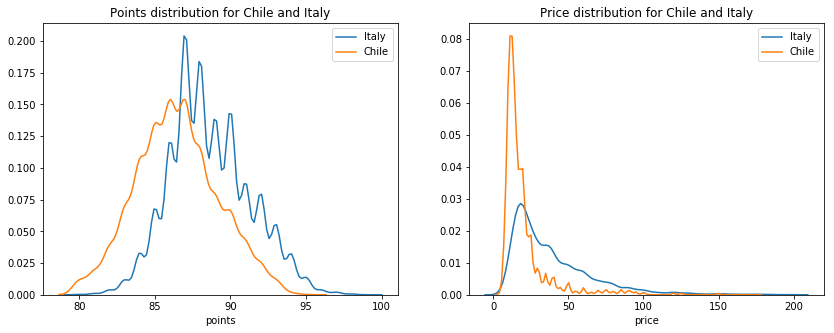

--------RESULTS OF-------Argentina Italy: (trained/tested) f1 
   trainedOn testedOn  medium_f1
5  Argentina    Italy   0.647923
   trainedOn   testedOn  medium_f1
66     Italy  Argentina   0.831661


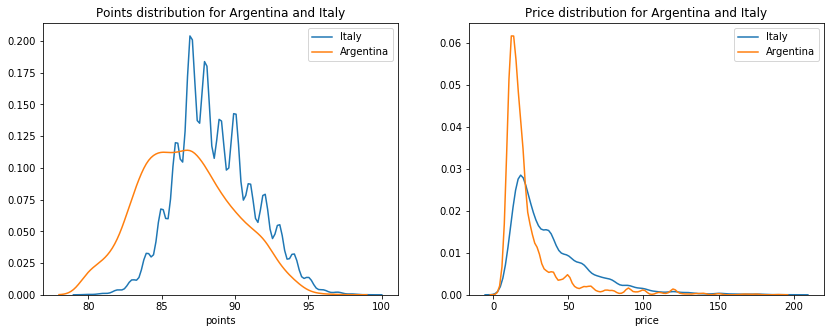

--------RESULTS OF-------Austria Italy: (trained/tested) f1 
   trainedOn testedOn  medium_f1
27   Austria    Italy   0.470727
   trainedOn testedOn  medium_f1
68     Italy  Austria   0.373614


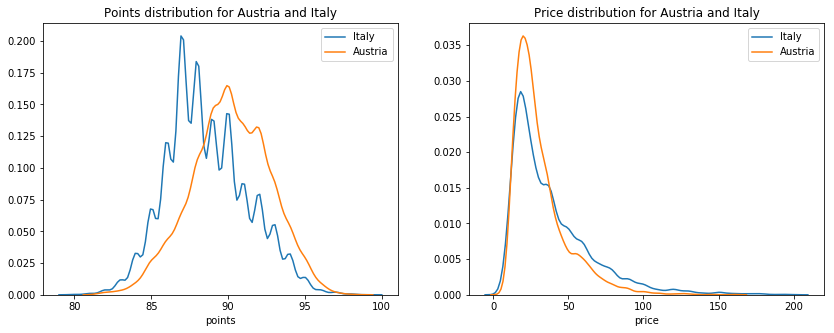

--------RESULTS OF-------Germany Italy: (trained/tested) f1 
   trainedOn testedOn  medium_f1
60   Germany    Italy   0.346966
   trainedOn testedOn  medium_f1
71     Italy  Germany   0.444906


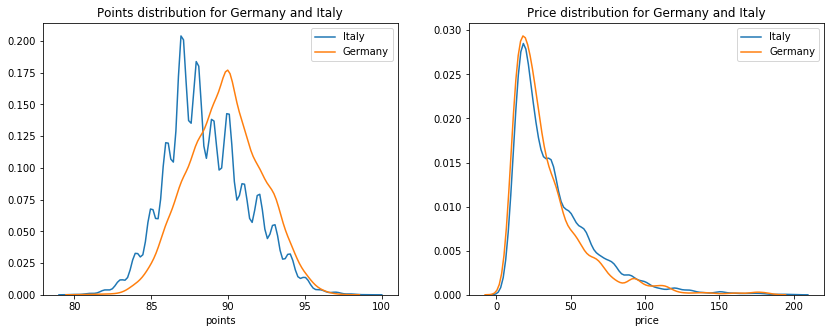

--------RESULTS OF-------Chile New Zealand: (trained/tested) f1 
   trainedOn     testedOn  medium_f1
39     Chile  New Zealand   0.622044
      trainedOn testedOn  medium_f1
80  New Zealand    Chile   0.560004


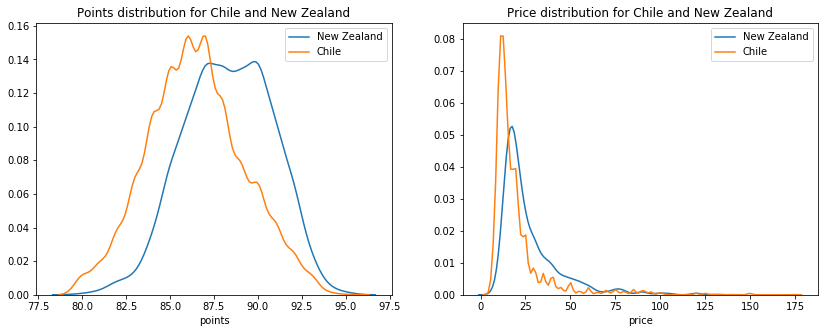

--------RESULTS OF-------Argentina New Zealand: (trained/tested) f1 
   trainedOn     testedOn  medium_f1
6  Argentina  New Zealand   0.622322
      trainedOn   testedOn  medium_f1
77  New Zealand  Argentina   0.592315


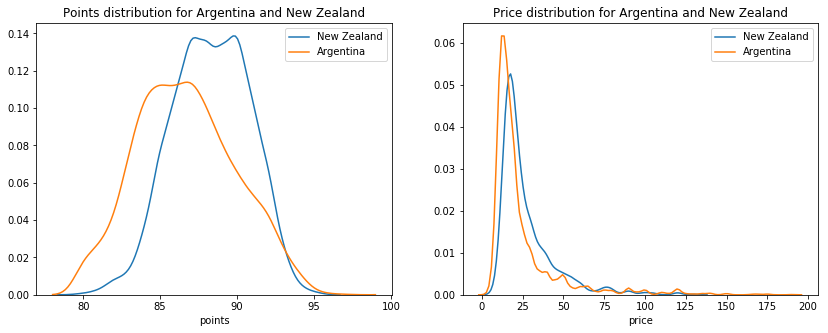

--------RESULTS OF-------Austria New Zealand: (trained/tested) f1 
   trainedOn     testedOn  medium_f1
28   Austria  New Zealand   0.477371
      trainedOn testedOn  medium_f1
79  New Zealand  Austria   0.428168


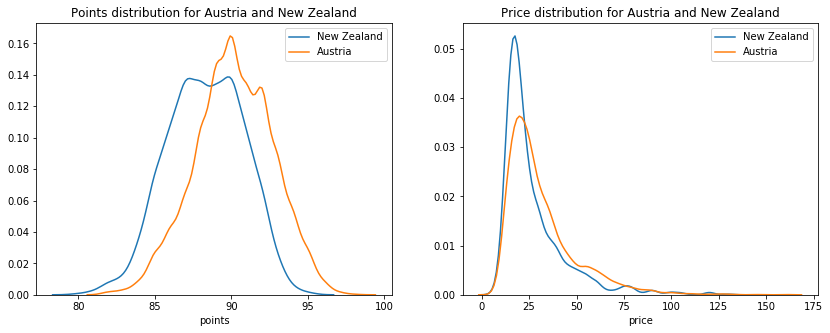

--------RESULTS OF-------Germany New Zealand: (trained/tested) f1 
   trainedOn     testedOn  medium_f1
61   Germany  New Zealand   0.399483
      trainedOn testedOn  medium_f1
82  New Zealand  Germany   0.344934


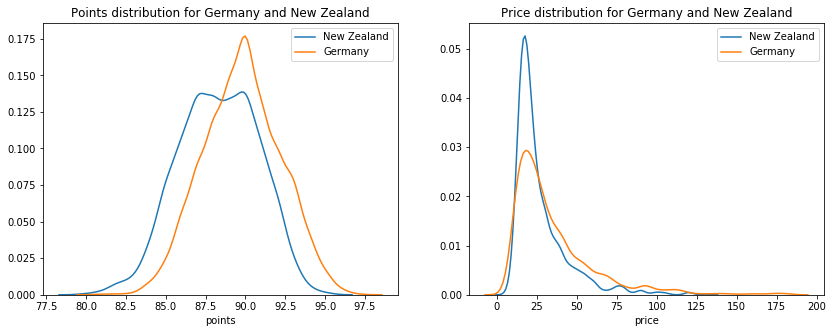

--------RESULTS OF-------Chile Portugal: (trained/tested) f1 
   trainedOn  testedOn  medium_f1
40     Chile  Portugal   0.699627
   trainedOn testedOn  medium_f1
91  Portugal    Chile   0.779529


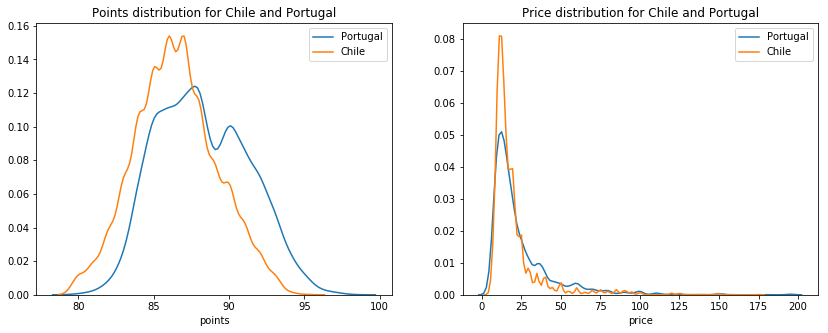

--------RESULTS OF-------Argentina Portugal: (trained/tested) f1 
   trainedOn  testedOn  medium_f1
7  Argentina  Portugal   0.731932
   trainedOn   testedOn  medium_f1
88  Portugal  Argentina    0.75629


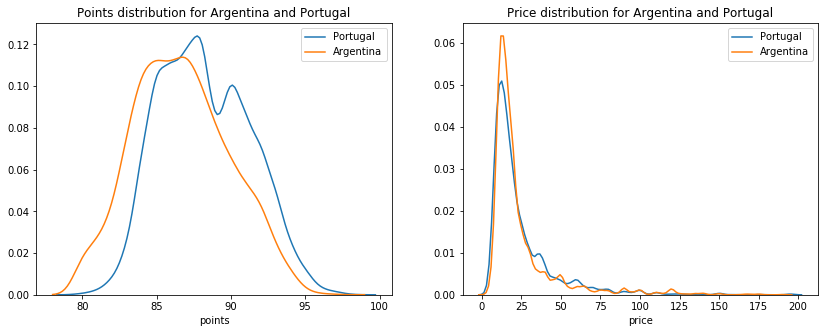

--------RESULTS OF-------Austria Portugal: (trained/tested) f1 
   trainedOn  testedOn  medium_f1
29   Austria  Portugal   0.578049
   trainedOn testedOn  medium_f1
90  Portugal  Austria   0.349556


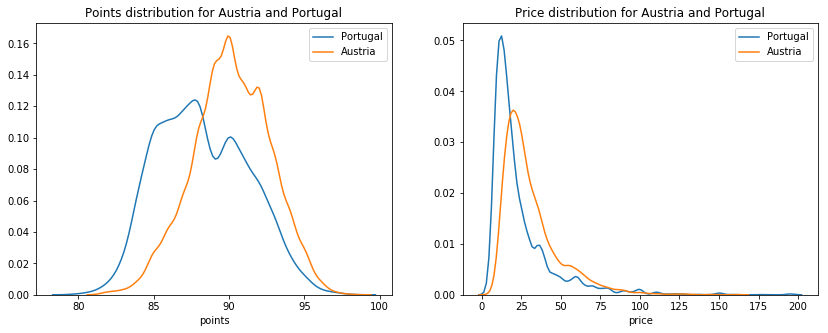

--------RESULTS OF-------Germany Portugal: (trained/tested) f1 
   trainedOn  testedOn  medium_f1
62   Germany  Portugal   0.554437
   trainedOn testedOn  medium_f1
93  Portugal  Germany   0.463799


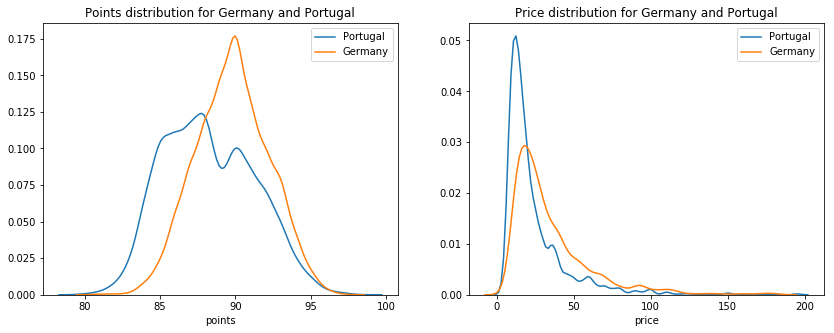

--------RESULTS OF-------Chile South Africa: (trained/tested) f1 
   trainedOn      testedOn  medium_f1
41     Chile  South Africa   0.773973
        trainedOn testedOn  medium_f1
102  South Africa    Chile   0.835899


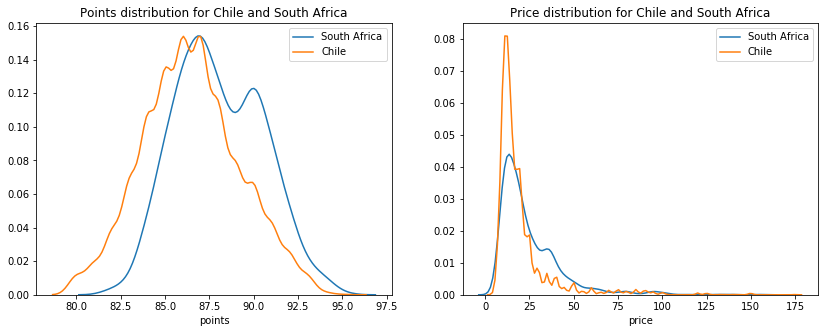

--------RESULTS OF-------Argentina South Africa: (trained/tested) f1 
   trainedOn      testedOn  medium_f1
8  Argentina  South Africa    0.75062
       trainedOn   testedOn  medium_f1
99  South Africa  Argentina   0.798781


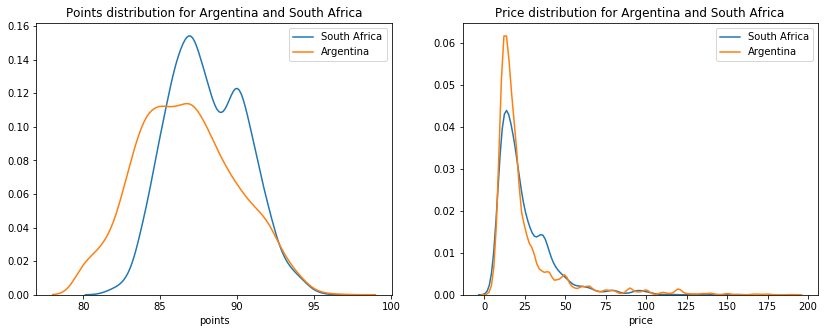

--------RESULTS OF-------Austria South Africa: (trained/tested) f1 
   trainedOn      testedOn  medium_f1
30   Austria  South Africa   0.569375
        trainedOn testedOn  medium_f1
101  South Africa  Austria   0.343463


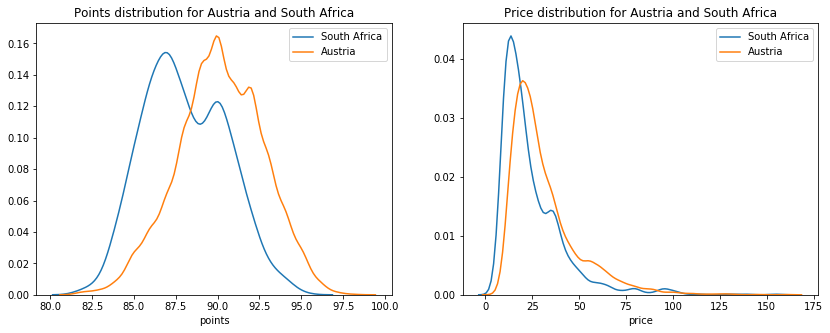

--------RESULTS OF-------Germany South Africa: (trained/tested) f1 
   trainedOn      testedOn  medium_f1
63   Germany  South Africa   0.518882
        trainedOn testedOn  medium_f1
104  South Africa  Germany    0.40024


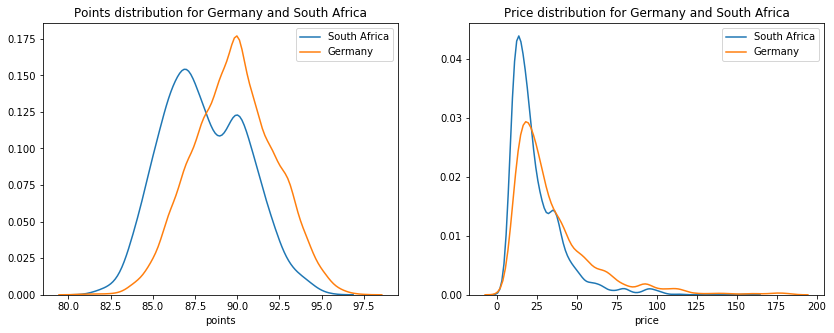

--------RESULTS OF-------Chile Spain: (trained/tested) f1 
   trainedOn testedOn  medium_f1
42     Chile    Spain   0.786804
    trainedOn testedOn  medium_f1
113     Spain    Chile   0.854004


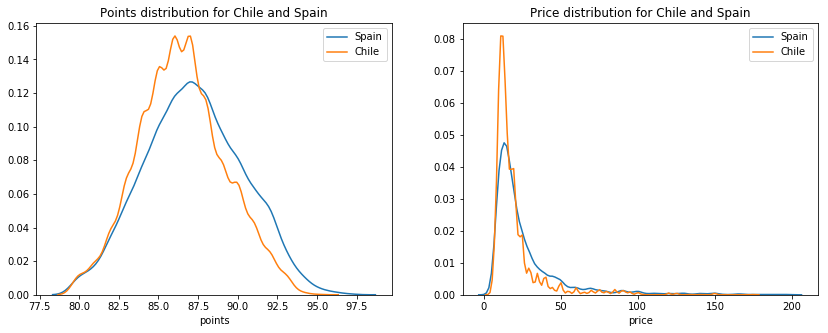

--------RESULTS OF-------Argentina Spain: (trained/tested) f1 
   trainedOn testedOn  medium_f1
9  Argentina    Spain   0.772832
    trainedOn   testedOn  medium_f1
110     Spain  Argentina   0.829516


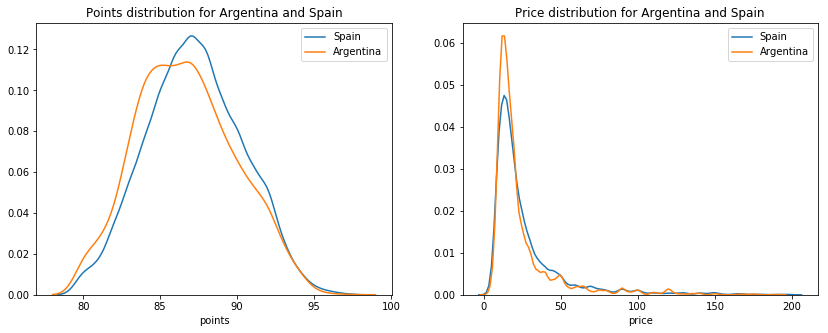

--------RESULTS OF-------Austria Spain: (trained/tested) f1 
   trainedOn testedOn  medium_f1
31   Austria    Spain   0.586681
    trainedOn testedOn  medium_f1
112     Spain  Austria   0.400411


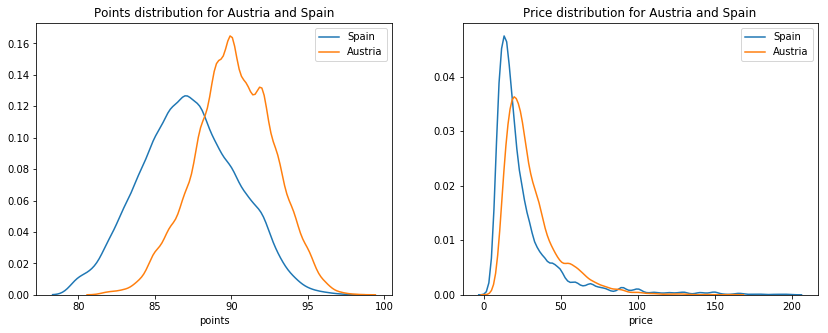

--------RESULTS OF-------Germany Spain: (trained/tested) f1 
   trainedOn testedOn  medium_f1
64   Germany    Spain    0.48174
    trainedOn testedOn  medium_f1
115     Spain  Germany   0.473101


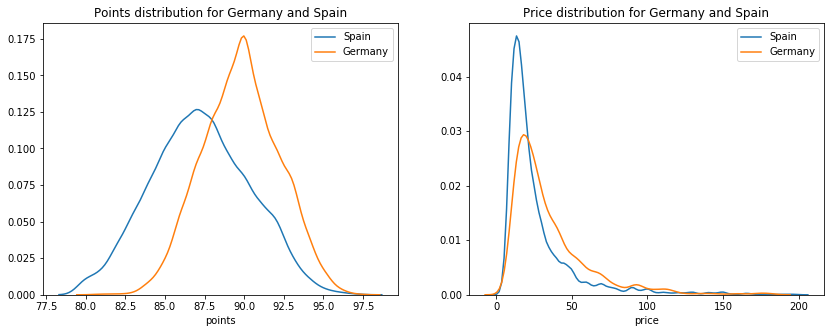

--------RESULTS OF-------Chile US: (trained/tested) f1 
   trainedOn testedOn  medium_f1
43     Chile       US   0.621479
    trainedOn testedOn  medium_f1
124        US    Chile   0.644564


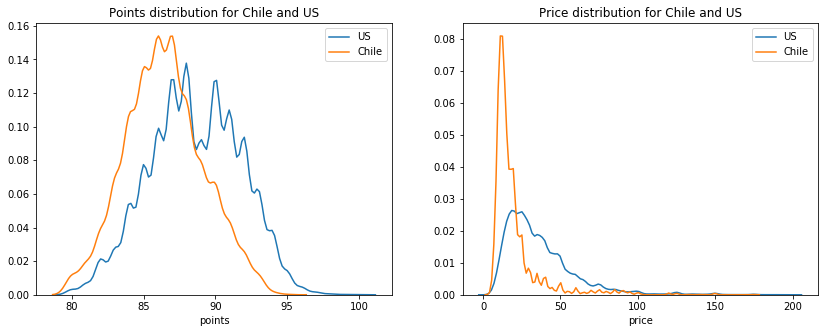

--------RESULTS OF-------Argentina US: (trained/tested) f1 
    trainedOn testedOn  medium_f1
10  Argentina       US   0.626142
    trainedOn   testedOn  medium_f1
121        US  Argentina   0.656747


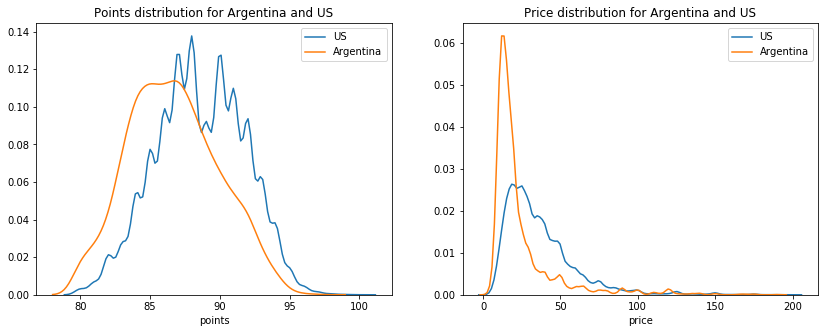

--------RESULTS OF-------Austria US: (trained/tested) f1 
   trainedOn testedOn  medium_f1
32   Austria       US   0.414062
    trainedOn testedOn  medium_f1
123        US  Austria    0.44198


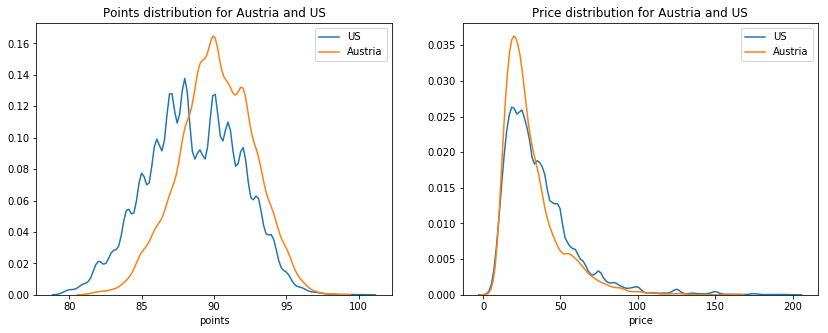

--------RESULTS OF-------Germany US: (trained/tested) f1 
   trainedOn testedOn  medium_f1
65   Germany       US   0.350202
    trainedOn testedOn  medium_f1
126        US  Germany    0.43451


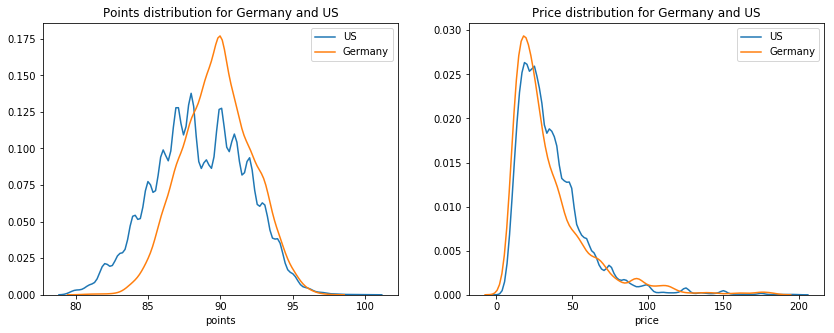

In [16]:
ofInterest = ["Chile","Argentina","Austria","Germany"]
for t1 in countries:
    for t in ofInterest:
        if t != t1:
            print("--------RESULTS OF-------"+ t + " " + t1 + ": (trained/tested) f1 ")
            row = t2[(t2["trainedOn"]==t) & (t2["testedOn"]==t1)]
            print(row)
            row1 = t2[(t2["trainedOn"]==t1) & (t2["testedOn"]==t)]
            print(row1)
            fig, ax = plt.subplots(figsize = (14, 5))
            temp = wine_base[(wine_base["country"] == t) & (wine_base["price"] < 200)]
            temp1 = wine_base[(wine_base["country"] == t1) & (wine_base["price"] < 200)]
            plt.subplot(1, 2, 1)
            plt.title("Points distribution for " + t + " and " + t1 )
            sns.distplot(temp1["points"],label=t1,bins = 20,hist=False,norm_hist=True,kde=True)
            sns.distplot(temp["points"],label=t,bins = 20,hist=False,norm_hist=True,kde=True)
            plt.legend()
            #plt.subplot(2,2,2)
            plt.subplot(1, 2, 2)
            plt.title("Price distribution for " + t + " and " + t1)
            sns.distplot(temp1["price"],label=t1,hist=False,norm_hist=True,kde=True)
            sns.distplot(temp["price"],label=t,hist=False,norm_hist=True,kde=True)
            plt.legend()
            #plt.subplot(2, 2,3)
            #plt.title("word_count distribution for " + t + " and " + t1)
            #sns.distplot(temp1["word_count"],label=t1,bins = 20,hist=False,norm_hist=True,kde=True)
            #sns.distplot(temp["word_count"],bins = 20,label=t,hist=False,norm_hist=True,kde=True)
            #plt.legend()
            #plt.subplot(2, 2,4)
            #plt.title("word2vec similarity distribution for " + t + " and " + t1)
            #sns.distplot(temp1["similarityTop3WinesByVariety"],label=t1,bins = 20,hist=False,norm_hist=True,kde=True)
            #sns.distplot(temp["similarityTop3WinesByVariety"],bins = 20,label=t,hist=False,norm_hist=True,kde=True)
            #plt.legend()
            plt.show()


Austrian and german points and price distributions are strikingly similar, while different from the others. Word count and word2vec similarities are basically always the same.

Maybe this is why some countries are better at prdicting some other ones, the price more the price and the points are similar, better the prediction. Because you have to keep in mind that at this level, no geographical information is provided. Taster names are a discriminant factor, but not at the level of price. Since the results at "higher levels" suggest that price is 80% of the decisions, it's safe to assume that this is the true discriminant factor while rating a wine.

if you look at us and argentina this seems not to be the case
